In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt
import seaborn as sns

## 1 定义导入路径

In [2]:
# 获取当前工作目录
current_dir = Path().absolute()

# 定义导入路径
folder_path = current_dir / "Inputs"

## 2 设定情景参数

In [3]:
# 本次优化问题的距离上限
max_dis = 300

# 抽样次数
num_samples = 100

# 发电技术种类
Gen_type = '02'

# Maximum mix rate of sludge mass in total fuel mass
MixRate = 0.05 # BAU: 0.05  # 0.1 0.15 0.2

# the ratio of lower bound to Maximum mix rate
l_ratio = 0.2

# MixRate = 0.05 ：0.2,0.5,0.8
# MixRate = 0.2 ：0.05,0.125,0.02

# Fuel Price 
Coal_Price_5500 = 557 # BAU：557 #674，791

# Growth rate of sludge production
growth_rate = 1 # BAU: 1 #1.0425, 1.1418

## 3 定义导出路径

In [4]:
# 优化结果
folder_GHG = current_dir / f"Outputs/GHG_{Gen_type}_{num_samples}_M{MixRate}_L{l_ratio}_{Coal_Price_5500}_S2_V4_excluding_supply_lb"
# folder_GHG = current_dir / f"Outputs/potential_GHG_{Gen_type}_{num_samples}_M{MixRate}_L{l_ratio}_{Coal_Price_5500}"
os.makedirs(folder_GHG, exist_ok=True)

# 优化日志
log_dir = folder_GHG / "logs"
os.makedirs(log_dir, exist_ok=True)

# 模型结构
# junk_dir =  folder_GHG / "junk_file"
# os.makedirs(junk_dir, exist_ok=True)

## 4 数据导入

In [5]:
# WWTP
file_WWTP = os.path.join(folder_path, "WWTP_corrected.xlsx")
df_WWTP = pd.read_excel(file_WWTP)

In [6]:
# CFPP
file_CFPP =  os.path.join(folder_path, "CFPP.xlsx")
df_CFPP = pd.read_excel(file_CFPP)

file_plant_coal =  os.path.join(folder_path, "coal-fired_power_plants_China_2020_operating.xlsx")
df_plant_coal = pd.read_excel(file_plant_coal)

In [7]:
# WIPP
file_WIPP =  os.path.join(folder_path, "WIPP.xlsx")
df_WIPP = pd.read_excel(file_WIPP)

file_plant_waste =  os.path.join(folder_path, "waste_inceration_plants_2020_operating.xlsx")
df_plant_waste = pd.read_excel(file_plant_waste)

In [8]:
# distance

file_distance_nation_CFPP = os.path.join(folder_path, f"distance_cfpp_potential.csv") #_firstfiltered
df_distance_nation_cfpp = pd.read_csv(file_distance_nation_CFPP)

file_distance_nation_WIPP = os.path.join(folder_path, f"distance_wipp_potential.csv")
df_distance_nation_wipp = pd.read_csv(file_distance_nation_WIPP)

In [9]:
# # Provincal data
file_intesity =  os.path.join(folder_path, "province_intensity.xlsx")
df_intesity = pd.read_excel(file_intesity)

# file_NC = os.path.join(folder_path, f"NC_categoried_{num_samples}.xlsx")
# df_nc = pd.read_excel(file_NC)

# Costs for Monte Carlo Simulation
# Net costs
file_NC =  os.path.join(folder_path, f"NC_old_nation_{num_samples}_monthly.csv")
df_nc = pd.read_csv(file_NC)

# TC_coal
file_TC_coal =  os.path.join(folder_path, f"TC_coal_{num_samples}.xlsx")
df_TC_coal = pd.read_excel(file_TC_coal)

# NC_cowaste
file_NC_cowaste =  os.path.join(folder_path, f"NC_cowaste_{num_samples}.xlsx")
df_NC_cowaste = pd.read_excel(file_NC_cowaste)

## 5 参数设定

In [10]:
## GHG emission factors (water content: 45%)

GHG_SludgeBurn = 0.0798 # GHG emissions of sludge burning on average (tCO2eq/t)
GHG_SludgeInci = -0.3132 # GHG emissions of sludge incineration with energy recovery (tCO2eq/t)
GHG_SludgeLandfill = 0.8672 # GHG emissions of sludge treatment by sanitary landfill (tCO2eq/t)
GHG_SludgeLandApp = (0.1065+0.3184)/2 # GHG emissions of sludge treatment by land application (tCO2eq/t)
GHG_SludgeBuild = -0.1701 # GHG emissions of sludge treatment by building material utilization (tCO2eq/t)
GHG_SludgeOther = 0.0891 # GHG emissions of sludge treatment by other applications (tCO2eq/t)

GHG_CoalBurn = 1.99 # GHG emissions of coal burning on average (tCO2eq/t)
GHG_CoalMini = 0.18 # GHG emission factor of coal mining and processing (tCO2eq/t)

GHG_SludgeTrans = 0.123/1000 # GHG emission factor of sludge transport (tCO2eq/km)

GHG_Elec_province = dict(zip(df_intesity['Province'], df_intesity['GHG_emis_tCO2eq/kWh']))
# GHG emission factor of grid electricity (tCO2eq/kWh)

In [11]:
## Costs (water content: 45%)

Coal_Price_province = dict(zip(df_intesity['Province'], df_intesity['Coal_price_index']*Coal_Price_5500))

In [12]:
# 煤电厂所在省份度电碳排放量 GHG_Elec_coal[j] 
# 煤电厂所在省份煤价 Coal_price[j]

region_j = df_plant_coal['Province']
GHG_Elec_coal = dict()
Coal_price= dict()

for j in range(len(region_j)):
    GHG_Elec_coal[j] = GHG_Elec_province[region_j[j]]
    Coal_price[j] = Coal_Price_province[region_j[j]]

In [13]:
# 生活垃圾焚烧发电厂所在省份度电碳排放量 GHG_Elec_waste[k] 

region_k = df_plant_waste['Pro_en']
GHG_Elec_waste = dict()
for k in range(len(region_k)):
    GHG_Elec_waste[k] = GHG_Elec_province[region_k[k]]

In [14]:
## 各月WWTP污泥提供量 SludgeSupply[i,m] 
## 各月厂污泥处置综合排放系数 SludgeTreatmentfactor[i,m]

month_WWTP = df_WWTP['Statistical month']
supply = df_WWTP['含水率45%时的总污泥处理量（吨/月）']
landapp = df_WWTP['含水率45%时的土地利用量（吨）']
building = df_WWTP['含水率45%时的建材利用量（吨）']
incineration = df_WWTP['含水率45%时的焚烧利用量（吨）']
landfill = df_WWTP['含水率45%时的卫生填埋量（吨）']
other = df_WWTP['含水率45%时的其他处置量（吨）']
item = df_WWTP['Plantcode']

SludgeSupply = dict() 
SludgeTreatmentfactor = dict() 
wwtp_counter = 0

for k in range(len(month_WWTP)):
    m = int(month_WWTP[k])-202000-1
    SludgeSupply[wwtp_counter, m] = round(supply[k]*growth_rate/1000,2)
    
    if supply[k] == 0:
        SludgeTreatmentfactor[wwtp_counter, m] = round(0,2)
    else: SludgeTreatmentfactor[wwtp_counter, m] = round((landapp[k]*GHG_SludgeLandApp+building[k]*GHG_SludgeBuild+
                                                                 incineration[k]*GHG_SludgeInci+landfill[k]*GHG_SludgeLandfill+
                                                                 other[k]*GHG_SludgeOther)/supply[k],2)
     
    if m == 11:
        wwtp_counter = wwtp_counter + 1

In [15]:
# 各WWTP污泥处置成本 NC_old[i,num]
NC_old = dict()
for k in range(len(df_nc['value'])):
    num_counter = df_nc['num'][k]
    i = df_nc['FID'][k]
    m = df_nc['m'][k]
    value = df_nc['value'][k]
    
    NC_old[num_counter,i,m] = value

# month_WWTP = df_WWTP['Statistical month']
# supply = df_WWTP['含水率45%时的总污泥处理量（吨/月）']
# landapp = df_WWTP['含水率45%时的土地利用量（吨）']
# building = df_WWTP['含水率45%时的建材利用量（吨）']
# incineration = df_WWTP['含水率45%时的焚烧利用量（吨）']
# landfill = df_WWTP['含水率45%时的卫生填埋量（吨）']
# other = df_WWTP['含水率45%时的其他处置量（吨）']
# # item = df_WWTP['项目编号']

# NC_landappli = df_nc['NC_landappli']
# NC_building = df_nc['NC_building']
# NC_inci = df_nc['NC_inci']
# NC_landfill = df_nc['NC_landfill']
# NC_other = df_nc['NC_other']

# NC_old_monthly = dict()

# index_counter = { num: 0 for num in range(num_samples)}



# for num in range(num_samples):
#     for k in range(len(month_WWTP)):
#         m = int(month_WWTP[k])-202000-1
        
#         wwtp_counter = index_counter[num]
    
#         if supply[k] == 0:
#             NC_old_monthly[num,wwtp_counter,m] = 0
#         else: NC_old_monthly[num,wwtp_counter,m] = (landapp[k]*NC_landappli[num]+
#                                              building[k]*NC_building[num]+
#                                              incineration[k]*NC_inci[num]+
#                                              landfill[k]*NC_landfill[num]+
#                                              other[k]*NC_other[num])/supply[k]
        
#         if m==11:
#             index_counter[num] = index_counter[num] + 1
            
# data = [(key[0], key[1], key[2], value) for key, value in NC_old_monthly.items()]
# df = pd.DataFrame(data, columns=['num','FID', 'm','value'])

# csv_path = fr'E:/Test/Inputs/costs/NC_old_nation_{num_samples}_monthly.csv'
# df.to_csv(csv_path, index=False)

In [16]:
NC_cowaste = dict()
TC_coal =dict()
for num in range(num_samples):
    NC_cowaste[num] = df_NC_cowaste['NC_cowaste'][num]
    TC_coal[num] = df_TC_coal['TC_coal'][num]

In [17]:
## 各月CFPP污泥需求量上限 SludgeDemand_CFPP[j,m]

month_CFPP = df_CFPP['Statistical month']
# demand_CFPP = df_CFPP['Monthly_Coal_Ele_tce'] * MixRate
demand_CFPP_1 = df_CFPP['Monthly_Coal_Ele_tce'] * MixRate
demand_CFPP_2 = df_CFPP['Monthly_Coal_Heat_tce'] * MixRate
demand_CFPP = demand_CFPP_1 + demand_CFPP_2

SludgeDemand_CFPP = dict() 
cfpp_counter = 0

for l in range(len(month_CFPP)):
    m_C = int(month_CFPP[l])-202000-1
    SludgeDemand_CFPP[cfpp_counter, m_C] = round(demand_CFPP[l]/0.7143/1000,2) #tce→kt
    
    if m_C == 11:
        cfpp_counter = cfpp_counter + 1

In [18]:
## 各月WIPP污泥需求量上限 SludgeDemand_WIPP[k,m]

month_WIPP = df_WIPP['Statistical month']
# demand_WIPP = df_WIPP['Monthly_Waste_Ele_t'] * MixRate
demand_WIPP_1 = df_WIPP['Monthly_Waste_Ele_t'] * MixRate
demand_WIPP_2 = df_WIPP['Monthly_Waste_Heat_t'] * MixRate
demand_WIPP = demand_WIPP_1 + demand_WIPP_2

SludgeDemand_WIPP = dict() 
wipp_counter = 0

for o in range(len(month_WIPP)):
    m_w = int(month_WIPP[o])-202000-1
    SludgeDemand_WIPP[wipp_counter, m_w] = demand_WIPP[o]/1000 
    
    if m_w == 11:
        wipp_counter = wipp_counter + 1

In [19]:
## WWTPs到CFPPs的距离 Distance_CFPP[i,j] km
## 加入时间维度，WWTPs到CFPPs的距离 annual_Distance_CFPP[i,j,m] km

distance_cfpp = df_distance_nation_cfpp['distance']
WWTP = df_distance_nation_cfpp['INPUT_FID']
CFPP = df_distance_nation_cfpp['NEAR_FID']

Distance_CFPP = dict()
annual_Distance_CFPP = dict()

for p in range(len(distance_cfpp)):
    wwtp = int(WWTP[p])
    cfpp = int(CFPP[p])
    Distance_CFPP[wwtp, cfpp] = round(distance_cfpp[p],2)
    
    for m in range(12):
        annual_Distance_CFPP[wwtp,cfpp,m] = round(distance_cfpp[p],2)   

In [20]:
## 经济距离约束下，可能与ith WWTP协同的煤电厂：WWTP_cfpp_possiblelinkage[i]:[(i,1),(i,7)]
## 经济距离约束下，可能与煤电厂协同的污水厂名单：wwtp_cfpp_list = []

WWTP_cfpp_possiblelinkage = dict()
wwtp_cfpp_list = []

for key in Distance_CFPP.keys():
    first_digit = key[0]
    
    if first_digit not in WWTP_cfpp_possiblelinkage:
        WWTP_cfpp_possiblelinkage[first_digit] = []  # 如果新键第一次出现，初始化对应值为空列表
        
    WWTP_cfpp_possiblelinkage[first_digit].append(key)  # 将键添加到对应的列表中  
    
    if first_digit not in wwtp_cfpp_list:
        wwtp_cfpp_list.append(first_digit) 

In [21]:
## 加入时间维度，经济距离约束下，可能与ith WWTP协同的煤电厂：annual_WWTP_cfpp_pl[i,m]

annual_WWTP_cfpp_pl = dict()


for wwtp in wwtp_cfpp_list:
    for m in range(12):
        annual_WWTP_cfpp_pl[wwtp, m] = []

for key in annual_Distance_CFPP.keys():
    digit_1 = key[0] # WTPPs
    digit_3 = key[2] # month
    annual_WWTP_cfpp_pl[digit_1,digit_3].append(key)

In [22]:
## 经济距离约束下，可能与jth CFPP配对的污水厂：CFPP_possiblelinkage[j]:[(i,j)]
## 经济距离约束下，可能与污水厂协同的煤电厂名单：cfpp_list = []

CFPP_possiblelinkage = {}
cfpp_list = []

for key in sorted(Distance_CFPP.keys(), key=lambda x: x[1]): # 将 Distance_CFPP 字典的键进行排序，排序的依据是键的第二个元素。
    second_digit = key[1]
    
    if second_digit not in CFPP_possiblelinkage:
        CFPP_possiblelinkage[second_digit] = [] 
        
    CFPP_possiblelinkage[second_digit].append(key) 
    
    if second_digit not in cfpp_list:
        cfpp_list.append(second_digit)    

In [23]:
## 加入时间维度，经济距离约束下，可能与jth CFPP配对的污水厂：annual_CFPP_possiblelinkage[j,m]

annual_CFPP_possiblelinkage = dict()


for cfpp in cfpp_list:
    for m in range(12):
        annual_CFPP_possiblelinkage[cfpp, m] = []

for key in annual_Distance_CFPP.keys():
    digit_2 = key[1] # CFPPs
    digit_3 = key[2] # m
    annual_CFPP_possiblelinkage[digit_2,digit_3].append(key)
    
## 比如：annual_Distance_CFPP.keys(): (0,465,0),(0,465,1),.....,(0,465,11),(0,464,0),(0,464,1),.....,(0,464,11)
## 则：annual_CFPP_possiblelinkage[j,m]→[0,0]:(0,465,0),(0,464,0) [0,1]:(0,465,1),(0,464,1)....

In [24]:
## WWTPs到WIPPs的距离 Distance_WIPP[i,k] km
## 加入时间维度，WWTPs到CFPPs的距离 annual_Distance_WIPP[i,k,m] km

distance_wipp = df_distance_nation_wipp['distance']
WWTP = df_distance_nation_wipp['INPUT_FID']
WIPP = df_distance_nation_wipp['NEAR_FID']

Distance_WIPP = dict()
annual_Distance_WIPP = dict()

for q in range(len(distance_wipp)):
    wwtp = int(WWTP[q])
    wipp = int(WIPP[q])
    Distance_WIPP[wwtp, wipp] = round(distance_wipp[q],2)
    
    for m in range(12):
        annual_Distance_WIPP[wwtp,wipp,m] = round(distance_wipp[q],2) 

In [25]:
## 经济距离约束下，可能与ith WWTP协同的垃圾焚烧电厂：WWTP_wipp_possiblelinkage[i]
## 经济距离约束下，可能协同的污水厂名单：wwtp_wipp_list = []

WWTP_wipp_possiblelinkage = dict()
wwtp_wipp_list = []

for key in Distance_WIPP.keys():
    first_digit = key[0]
    
    if first_digit not in WWTP_wipp_possiblelinkage:
        WWTP_wipp_possiblelinkage[first_digit] = []  
        
    WWTP_wipp_possiblelinkage[first_digit].append(key)   
    
    if first_digit not in wwtp_wipp_list:
        wwtp_wipp_list.append(first_digit) 

In [26]:
## 加入时间维度，经济距离约束下，可能与ith WWTP协同的垃圾焚烧电厂：annual_WWTP_wipp_pl[i,m]

annual_WWTP_wipp_pl = dict()


for wwtp in wwtp_wipp_list:
    for m in range(12):
        annual_WWTP_wipp_pl[wwtp, m] = []

for key in annual_Distance_WIPP.keys():
    digit_1 = key[0]
    digit_3 = key[2]
    annual_WWTP_wipp_pl[digit_1,digit_3].append(key)

In [27]:
## 经济距离约束下，可能与kth WIPP配对的污水厂：WIPP_possiblelinkage[k]:[(i,k)]
## 经济距离约束下，可能协同的电厂名单：wipp_list = []

WIPP_possiblelinkage = dict()
wipp_list = []

for key in sorted(Distance_WIPP.keys(), key=lambda x: x[1]): 
    second_digit = key[1]
    
    if second_digit not in WIPP_possiblelinkage:
        WIPP_possiblelinkage[second_digit] = [] 
        
    WIPP_possiblelinkage[second_digit].append(key) 
    
    if second_digit not in wipp_list:
        wipp_list.append(second_digit)    

In [28]:
## 加入时间维度，经济距离约束下，可能与kth WIPP配对的污水厂：annual_WIPP_possiblelinkage[k,m]

annual_WIPP_possiblelinkage = dict()


for wipp in wipp_list:
    for m in range(12):
        annual_WIPP_possiblelinkage[wipp, m] = []

for key in annual_Distance_WIPP.keys():
    digit_2 = key[1]
    digit_3 = key[2]
    annual_WIPP_possiblelinkage[digit_2,digit_3].append(key)

## 6 模型构建与求解：煤电+生活垃圾焚烧发电

In [29]:
# 封装函数
# 单位：ktCO2eq, Thounsand CNY

def Optimize_GHG_02_Nation(num,log_filepath):

    # Model Parameters
    I = 5218 #No.WWTPs
    M = 12 # Months

    # Create a new model
    model = gp.Model("GHG_emission_nation")
    
    # Define the folder path of log file
    model.setParam("LogFile", log_filepath)

    # Create variables
    weight_cfpp = model.addVars(annual_Distance_CFPP.keys(),lb=0,vtype = GRB.CONTINUOUS,name='weight_cfpp')
    weight_wipp = model.addVars(annual_Distance_WIPP.keys(),lb=0,vtype = GRB.CONTINUOUS,name='weight_wipp')
#     z_cfpp = model.addVars(cfpp_list,vtype = GRB.BINARY, name='z_cfpp')
#     z_wipp = model.addVars(wipp_list,vtype = GRB.BINARY, name='z_wipp')


    # Define the component of objective
    # onsite fuel combustion - coal
    obj1 = gp.quicksum(weight_cfpp[index]*(GHG_SludgeBurn-0.48*GHG_CoalBurn) 
                       for index in annual_Distance_CFPP.keys())

    # sludge treatment - coal
    obj2 = gp.quicksum(-weight_cfpp[index]*SludgeTreatmentfactor[index[0],index[2]] 
                       for index in annual_Distance_CFPP.keys())

    # sludge dehydration - coal
    obj3 = gp.quicksum(weight_cfpp[index]*28*GHG_Elec_coal[index[1]] 
                       for index in annual_Distance_CFPP.keys())

    # sludge transport - coal
    obj4 = gp.quicksum(weight_cfpp[index]*GHG_SludgeTrans*annual_Distance_CFPP[index] 
                       for index in annual_Distance_CFPP.keys())

    # offsite coal mining and processing - coal
    obj5 = gp.quicksum(-weight_cfpp[index]*0.48*GHG_CoalMini 
                       for index in annual_Distance_CFPP.keys())

    # onsite fuel combustion - waste
    obj6 = gp.quicksum(weight_wipp[wipp_index]*GHG_SludgeBurn 
                       for wipp_index in annual_Distance_WIPP.keys())

    # sludge treatment - waste
    obj7 = gp.quicksum(-weight_wipp[wipp_index]*SludgeTreatmentfactor[wipp_index[0],wipp_index[2]] 
                       for wipp_index in annual_Distance_WIPP.keys())

    # sludge dehydration - waste
    obj8 = gp.quicksum(weight_wipp[wipp_index]*28*GHG_Elec_waste[wipp_index[1]] 
                       for wipp_index in annual_Distance_WIPP.keys())

    # sludge transport - waste
    obj9 = gp.quicksum(weight_wipp[wipp_index]*GHG_SludgeTrans*annual_Distance_WIPP[wipp_index] 
                       for wipp_index in annual_Distance_WIPP.keys())

    # Set objective
    model.setObjective(obj1+obj2+obj3+obj4+obj5+obj6+obj7+obj8+obj9
                       ,GRB.MINIMIZE)
    

    # Add constraints: 污水厂污泥供给上限约束
    for i in range(I):
        for m in range(M):
            ## 初始化提供给不同电厂的污泥量总和
            supply_to_cfpp = 0
            supply_to_wipp = 0
            flag = 0

            if i in WWTP_cfpp_possiblelinkage.keys(): # 检查 i 污水厂- j 煤电厂是否在可能的协同方案中
                for linkage_cfpp in WWTP_cfpp_possiblelinkage[i]:
                    j = linkage_cfpp[1]
                    supply_to_cfpp += weight_cfpp[i,j,m]
            else:
                flag += 1

            if i in WWTP_wipp_possiblelinkage.keys(): # 检查 i 污水厂- k生活垃圾焚烧厂是否在可能的协同方案中
                for linkage_wipp in WWTP_wipp_possiblelinkage[i]:
                    k = linkage_wipp[1]
                    supply_to_wipp += weight_wipp[i,k,m]
            else:
                flag += 1

            if flag < 2:
                model.addConstr(supply_to_cfpp + supply_to_wipp <= SludgeSupply[i,m])     

                
    # Add constraints: 电厂污泥需求上限约束
    model.addConstrs(gp.quicksum(weight_cfpp[cfpp_link] for cfpp_link in annual_CFPP_possiblelinkage[j,m]) <= SludgeDemand_CFPP[j,m] #*z_cfpp[j] 
                     for j in cfpp_list for m in range(M))
    model.addConstrs(gp.quicksum(weight_wipp[wipp_link] for wipp_link in annual_WIPP_possiblelinkage[k,m]) <= SludgeDemand_WIPP[k,m] #*z_wipp[k] 
                     for k in wipp_list for m in range(M))
    
    
    # Add constraints: 电厂污泥需求下限约束
#     model.addConstrs(gp.quicksum(weight_cfpp[cfpp_link] for cfpp_link in annual_CFPP_possiblelinkage[j,m]) >= l_ratio*SludgeDemand_CFPP[j,m]*z_cfpp[j] 
#                      for j in cfpp_list for m in range(M))
#     model.addConstrs(gp.quicksum(weight_wipp[wipp_link] for wipp_link in annual_WIPP_possiblelinkage[k,m]) >= l_ratio*SludgeDemand_WIPP[k,m]*z_wipp[k] 
#                      for k in wipp_list for m in range(M))
    
    
    # Add constraints:经济约束(按电厂添加)
    model.addConstrs(
        gp.quicksum(weight_cfpp[cfpp_link[0],j,m] * (Distance_CFPP[cfpp_link[0],j]*0.65-0.48*Coal_price[j]-NC_old[num,cfpp_link[0],m]+TC_coal[num]) 
                    for m in range(M) 
                    for cfpp_link in annual_CFPP_possiblelinkage[j,m]
                   ) <= 0 
        for j in cfpp_list
    )
    
    model.addConstrs(
        gp.quicksum(weight_wipp[wipp_link[0],k,m]*(Distance_WIPP[wipp_link[0], k]*0.65 - NC_old[num,wipp_link[0],m] + NC_cowaste[num]-100)
                    for m in range(M)
                    for wipp_link in annual_WIPP_possiblelinkage[k,m]
                   ) <= 0
        for k in wipp_list
    )
    
    
    # 设置 MIPGap 参数，设定为 0.01（1%）
    model.setParam('MIPGap', 0.01)
#     model.setParam('Method', 2)
#     model.setParam('NodeMethod', 2)
#     model.setParam('TimeLimit',7200)
#     model.write(f'{log_dir}/mymodel_{num}.mps')
                
    # Optimize model
    model.optimize()
    
    # 获取目标函数值
    obj_expr = model.getObjective()
    obj_value = obj_expr.getValue()
    
    # 获取各部分目标函数值
    obj_values = [obj1, obj2, obj3, obj4, obj5, obj6, obj7, obj8, obj9]
    obj_val_list = [obj.getValue() for obj in obj_values]
    
    return model,weight_cfpp,weight_wipp,obj_value,*obj_val_list #z_cfpp,z_wipp,

In [30]:
# 函数调用并储存结果

unit_obj_02 = []

# for num in range(num_samples): #num_samples
for num in range(100):

    log_filename = f"GHG_02_nation_{num}.log"
    log_filepath = os.path.join(log_dir, log_filename)    
    
    model,weight_cfpp,weight_wipp,obj_value,*obj_vals = Optimize_GHG_02_Nation(num,log_filepath)
#     model,weight_cfpp,weight_wipp,z_cfpp,z_wipp,obj_value,*obj_vals = Optimize_GHG_02_Nation(num,log_filepath)
    obj1_val, obj2_val, obj3_val, obj4_val, obj5_val, obj6_val, obj7_val, obj8_val, obj9_val = obj_vals
    
    # 获取目标函数值
    mix_1 = obj1_val+obj2_val+obj3_val+obj4_val+obj5_val    
        
    # 获取决策变量优化结果
    opt_weight_cfpp = model.getAttr("X",weight_cfpp)
    opt_weight_wipp = model.getAttr("X",weight_wipp)
#     opt_z_cfpp = model.getAttr("X",z_cfpp)
#     opt_z_wipp = model.getAttr("X",z_wipp)
    
    # 保存决策变量优化结果
    linkage_cfpp = {key: value for key, value in opt_weight_cfpp.items() if value > 0.0001} 
    cfpp = []
    for key,value in linkage_cfpp.items():
        i = key[0]
        j = key[1]
        m = key[2]
        cfpp.append([i, j, m, linkage_cfpp[key]]) 

    df_cfpp = pd.DataFrame(cfpp, columns=['I', 'J', 'M', 'opt_weight_cfpp'])
    excel_filename = os.path.join(folder_GHG, f"GHG_02_cfpp_{num}.csv")
    df_cfpp.to_csv(excel_filename, index=False)
    w_cfpp = df_cfpp['opt_weight_cfpp'].sum()
    
    linkage_wipp = {key: value for key, value in opt_weight_wipp.items() if value > 0.0001}
    wipp = []
    for key,value in linkage_wipp.items():
        i = key[0]
        k = key[1]
        m = key[2]
        wipp.append([i, k, m, linkage_wipp[key]]) 

    df_wipp = pd.DataFrame(wipp, columns=['I', 'K', 'M', 'opt_weight_wipp'])
    w_wipp = df_wipp['opt_weight_wipp'].sum()
    
    filename_wipp = os.path.join(folder_GHG, f"GHG_02_wipp_{num}.csv")
    df_wipp.to_csv(filename_wipp, index=False)
    
    n_cfpp = df_cfpp['J'].nunique()
    n_wwtp_to_cfpp = df_cfpp['I'].nunique()
    n_wipp = df_wipp['K'].nunique()
    n_wwtp_to_wipp = df_wipp['I'].nunique()
    
#     z_cfpp_val = {key: value for key, value in opt_z_cfpp.items()}
#     df_m_cfpp = pd.DataFrame(list(z_cfpp_val.items()), columns=['J', 'z_cfpp'])
#     df_m_cfpp.to_csv(os.path.join(folder_GHG, f"z_cfpp_{num}.csv"), index=False)
#     n_cfpp = df_m_cfpp['z_cfpp'].sum()

#     z_wipp_val = {key: value for key, value in opt_z_wipp.items()}
#     df_m_wipp = pd.DataFrame(list(z_wipp_val.items()), columns=['K', 'z_wipp'])
#     df_m_wipp.to_csv(os.path.join(folder_GHG, f"z_wipp_{num}.csv"), index=False)
#     n_wipp = df_m_wipp['z_wipp'].sum()
    
    unit_obj_02.append({
        'num':num,
        'obj1': obj1_val,
        'obj2': obj2_val,
        'obj3': obj3_val,
        'obj4': obj4_val,
        'obj5': obj5_val,
        'obj6': obj6_val,
        'obj7': obj7_val,
        'obj8': obj8_val,
        'obj9': obj9_val,
        'mix_1': mix_1,        
        'mix_2': obj_value-mix_1,
        'obj_value': obj_value,
        'opt_weight_cfpp': w_cfpp,
        'opt_weight_wipp': w_wipp,
        'w_total': w_cfpp+w_wipp,
        'n_cfpp': n_cfpp,
        'n_wipp': n_wipp,
        'n_wwtp_to_cfpp': n_wwtp_to_cfpp,
        'n_wwtp_to_wipp': n_wwtp_to_wipp       
        })  
        

    
df_unit_obj_02 = pd.DataFrame(unit_obj_02)

analysis_folder = os.path.join(folder_GHG, "analysis")
os.makedirs(analysis_folder, exist_ok=True)
file_result = os.path.join(analysis_folder, f"result_02_{num_samples}_{max_dis}.csv")
df_unit_obj_02.to_csv(file_result,index=False)

Set parameter LicenseID to value 2691858
Set parameter LogFile to value "E:\Test\Outputs\GHG_02_100_M0.05_L0.2_557_S2_V4_excluding_supply_lb\logs\GHG_02_nation_0.log"
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.01

Optimize a model with 52227 rows, 1101108 columns and 3303324 nonzeros
Model fingerprint: 0x673fb84e
Coefficient statistics:
  Matrix range     [2e-03, 2e+03]
  Objective range  [2e-03, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 7e+01]
Presolve removed 5266 rows and 69966 columns
Presolve time: 1.69s
Presolved: 46961 rows, 1031142 columns, 3091271 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.91

  26  -1.37516671e+04 -2.22673310e+04  1.53e-05 2.44e-15  4.04e-03    14s
  27  -1.38200584e+04 -2.08774130e+04  1.18e-05 2.00e-15  3.35e-03    14s
  28  -1.38982954e+04 -1.96793798e+04  8.67e-06 1.78e-15  2.74e-03    15s
  29  -1.39649110e+04 -1.86572319e+04  6.70e-06 1.33e-15  2.22e-03    15s
  30  -1.39992736e+04 -1.78332599e+04  5.86e-06 1.11e-15  1.82e-03    16s
  31  -1.40739086e+04 -1.70308003e+04  4.43e-06 9.71e-16  1.40e-03    16s
  32  -1.41293358e+04 -1.65582372e+04  3.63e-06 8.88e-16  1.15e-03    17s
  33  -1.41679159e+04 -1.61356073e+04  3.17e-06 6.66e-16  9.33e-04    18s
  34  -1.42091255e+04 -1.59018099e+04  2.78e-06 8.88e-16  8.03e-04    18s
  35  -1.42490284e+04 -1.56611288e+04  2.39e-06 8.88e-16  6.69e-04    19s
  36  -1.43173748e+04 -1.54497266e+04  1.76e-06 6.66e-16  5.37e-04    19s
  37  -1.43457081e+04 -1.52843411e+04  1.56e-06 4.44e-16  4.45e-04    20s
  38  -1.43883447e+04 -1.52007710e+04  1.28e-06 5.68e-14  3.85e-04    20s
  39  -1.44227359e+04 -1.50717704e+04 

  31  -1.44495970e+04 -1.52338159e+04  9.17e-02 1.97e-15  1.58e-03    16s
  32  -1.44616251e+04 -1.51571097e+04  8.46e-02 2.96e-15  1.40e-03    17s
  33  -1.44888546e+04 -1.50836444e+04  6.89e-02 1.84e-15  1.19e-03    17s
  34  -1.45108819e+04 -1.50424532e+04  5.90e-02 2.08e-15  1.06e-03    18s
  35  -1.45421573e+04 -1.49837287e+04  4.62e-02 1.78e-15  8.81e-04    18s
  36  -1.45583130e+04 -1.49403593e+04  4.05e-02 1.78e-15  7.62e-04    19s
  37  -1.45780375e+04 -1.48760272e+04  3.43e-02 1.78e-15  5.96e-04    19s
  38  -1.46116588e+04 -1.48355798e+04  2.45e-02 1.78e-15  4.47e-04    19s
  39  -1.46240087e+04 -1.48188511e+04  2.13e-02 1.62e-15  3.89e-04    20s
  40  -1.46422297e+04 -1.48038856e+04  1.66e-02 1.88e-15  3.21e-04    20s
  41  -1.46537647e+04 -1.47898410e+04  1.42e-02 1.78e-15  2.71e-04    21s
  42  -1.46642389e+04 -1.47763380e+04  1.21e-02 2.00e-15  2.23e-04    21s
  43  -1.46763647e+04 -1.47658899e+04  9.69e-03 1.78e-15  1.78e-04    22s
  44  -1.46840109e+04 -1.47596105e+04 


Non-default parameters:
MIPGap  0.01

Optimize a model with 52227 rows, 1101108 columns and 3303324 nonzeros
Model fingerprint: 0x7362a97a
Coefficient statistics:
  Matrix range     [3e-03, 2e+03]
  Objective range  [2e-03, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 7e+01]
Presolve removed 5436 rows and 72583 columns
Presolve time: 1.98s
Presolved: 46791 rows, 1028525 columns, 3083410 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 1.03s

Barrier statistics:
 AA' NZ     : 2.059e+06
 Factor NZ  : 4.291e+06 (roughly 500 MB of memory)
 Factor Ops : 9.443e+08 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.67645725e+07 -4.96802857e+04  2.40e+05 5.01e+00  9.27e+02     5s
   1  -8.44847785e+06 -6.93018358e+05  5.52e+04 3.12e-01  2.15e+02     5s
   2  -5.1813

Model fingerprint: 0x2ee65ae8
Coefficient statistics:
  Matrix range     [4e-03, 2e+03]
  Objective range  [2e-03, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 7e+01]
Presolve removed 5427 rows and 72454 columns
Presolve time: 1.59s
Presolved: 46800 rows, 1028654 columns, 3083767 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.90s

Barrier statistics:
 AA' NZ     : 2.059e+06
 Factor NZ  : 4.293e+06 (roughly 500 MB of memory)
 Factor Ops : 9.460e+08 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.80078008e+07 -5.21479233e+04  3.68e+05 4.14e+00  1.23e+03     4s
   1  -6.67036967e+06 -6.27866395e+05  1.37e+05 2.66e+00  4.61e+02     4s
   2  -8.15178675e+05 -8.53076212e+05  1.66e+04 1.07e-14  5.80e+01     5s
   3  -2.66333174e+05 -6.86940018e+05  5.31e+03 8

  10  -5.76888654e+04 -1.28961128e+05  1.02e+02 3.19e-04  7.44e-01     7s
  11  -4.04405892e+04 -1.01207354e+05  6.45e+01 2.07e-04  4.95e-01     8s
  12  -2.23498272e+04 -7.68225045e+04  2.63e+01 1.21e-04  2.52e-01     8s
  13  -1.58627334e+04 -5.65249931e+04  1.28e+01 6.60e-05  1.43e-01     8s
  14  -1.16463369e+04 -3.55515788e+04  4.08e+00 1.96e-05  6.19e-02     9s
  15  -1.11855956e+04 -2.84321179e+04  3.07e+00 1.17e-05  4.34e-02     9s
  16  -1.09091280e+04 -2.65255872e+04  2.42e+00 9.02e-05  3.76e-02     9s
  17  -1.07814101e+04 -2.30653565e+04  2.10e+00 7.40e-06  2.95e-02    10s
  18  -1.05667341e+04 -2.25972555e+04  1.49e+00 7.40e-06  2.72e-02    10s
  19  -1.03951831e+04 -1.94016819e+04  9.54e-01 4.52e-06  1.95e-02    10s
  20  -1.03849443e+04 -1.70516649e+04  6.56e-01 3.07e-06  1.41e-02    11s
  21  -1.04153564e+04 -1.53674275e+04  5.13e-01 3.44e-05  1.04e-02    12s
  22  -1.04824449e+04 -1.45219611e+04  4.00e-01 1.40e-06  8.39e-03    12s
  23  -1.05838645e+04 -1.38698698e+04 

   5  -2.86749039e+05 -3.37434082e+05  7.71e+02 7.38e-04  2.99e+00     6s
   6  -2.02077747e+05 -2.66236303e+05  5.32e+02 8.82e-04  2.04e+00     6s
   7  -1.15484603e+05 -1.97853820e+05  2.88e+02 7.11e-15  1.13e+00     6s
   8  -6.06947156e+04 -1.61292143e+05  1.34e+02 7.11e-15  6.18e-01     7s
   9  -3.24825503e+04 -1.26414620e+05  5.38e+01 7.11e-15  3.40e-01     7s
  10  -2.17162351e+04 -7.89640610e+04  2.32e+01 7.11e-15  1.72e-01     7s
  11  -1.87313425e+04 -5.28503728e+04  1.45e+01 7.11e-15  9.95e-02     8s
  12  -1.65185449e+04 -4.04585173e+04  7.74e+00 8.88e-15  6.23e-02     8s
  13  -1.58664138e+04 -3.08702407e+04  5.66e+00 3.34e-05  3.94e-02     8s
  14  -1.52581716e+04 -2.87850753e+04  3.54e+00 3.25e-05  3.24e-02     9s
  15  -1.47978503e+04 -2.32469296e+04  1.80e+00 1.90e-05  1.90e-02     9s
  16  -1.47125290e+04 -2.10864377e+04  1.26e+00 4.80e-15  1.39e-02     9s
  17  -1.46895123e+04 -2.03407569e+04  1.11e+00 8.66e-06  1.23e-02    10s
  18  -1.46673162e+04 -1.92092906e+04 

  46  -1.59188646e+04 -1.59499318e+04  4.46e-05 4.30e-07  2.98e-05    24s

Barrier performed 46 iterations in 24.29 seconds (18.48 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Iteration    Objective       Primal Inf.    Dual Inf.      Time
   74745   -1.5941600e+04   0.000000e+00   0.000000e+00     25s
Extra simplex iterations after uncrush: 251
   74996   -1.5941600e+04   0.000000e+00   0.000000e+00     25s

Solved in 74996 iterations and 25.47 seconds (19.65 work units)
Optimal objective -1.594160047e+04
Set parameter LogFile to value "E:\Test\Outputs\GHG_02_100_M0.05_L0.2_557_S2_V4_excluding_supply_lb\logs\GHG_02_nation_11.log"
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-defaul

   9  -7.56494929e+04 -2.03319729e+05  1.79e+02 4.64e-02  3.73e-01     7s
  10  -4.90886429e+04 -1.43685324e+05  1.03e+02 2.53e-02  2.11e-01     7s
  11  -3.44654250e+04 -1.11951032e+05  6.16e+01 1.61e-02  1.30e-01     7s
  12  -2.39930982e+04 -9.71708458e+04  3.19e+01 1.28e-02  8.12e-02     8s
  13  -1.83373327e+04 -6.63646455e+04  1.56e+01 7.18e-03  4.23e-02     8s
  14  -1.62244324e+04 -5.41098423e+04  9.41e+00 5.58e-03  2.86e-02     8s
  15  -1.49131915e+04 -4.10508168e+04  5.31e+00 3.24e-03  1.76e-02     9s
  16  -1.47201714e+04 -3.45846466e+04  4.67e+00 2.37e-03  1.34e-02     9s
  17  -1.44742369e+04 -3.00890429e+04  3.80e+00 2.07e-03  1.03e-02     9s
  18  -1.41609995e+04 -2.69308484e+04  2.61e+00 1.56e-03  7.89e-03    10s
  19  -1.40019639e+04 -2.46967327e+04  1.87e+00 1.24e-03  6.30e-03    10s
  20  -1.38626850e+04 -2.24159115e+04  1.12e+00 9.25e-04  4.75e-03    10s
  21  -1.38566383e+04 -2.08159528e+04  8.98e-01 7.50e-04  3.81e-03    11s
  22  -1.38544942e+04 -1.96747773e+04 

  43  -1.42485347e+04 -1.44530570e+04  2.18e-05 1.48e-06  9.74e-05    23s
  44  -1.42686781e+04 -1.44347379e+04  1.76e-05 1.23e-06  7.91e-05    23s
  45  -1.42850804e+04 -1.44168190e+04  1.45e-05 9.24e-07  6.27e-05    24s
  46  -1.43071440e+04 -1.44085199e+04  1.03e-05 7.84e-07  4.83e-05    24s
  47  -1.43189999e+04 -1.43981208e+04  8.50e-06 6.03e-07  3.77e-05    25s
  48  -1.43271682e+04 -1.43960883e+04  7.35e-06 5.46e-07  3.28e-05    26s
  49  -1.43375097e+04 -1.43920214e+04  5.69e-06 4.40e-07  2.60e-05    26s
  50  -1.43441186e+04 -1.43890578e+04  4.70e-06 3.56e-07  2.14e-05    27s
  51  -1.43509801e+04 -1.43875440e+04  3.77e-06 3.17e-07  1.74e-05    27s
  52  -1.43539752e+04 -1.43862650e+04  3.33e-06 2.76e-07  1.54e-05    28s
  53  -1.43595554e+04 -1.43845249e+04  2.49e-06 2.12e-07  1.19e-05    28s
  54  -1.43630805e+04 -1.43835766e+04  2.03e-06 1.72e-07  9.76e-06    29s
  55  -1.43676558e+04 -1.43824773e+04  1.49e-06 1.25e-07  7.06e-06    29s
  56  -1.43696044e+04 -1.43821013e+04 



Solved with dual simplex
Extra simplex iterations after uncrush: 1
Iteration    Objective       Primal Inf.    Dual Inf.      Time
   94347   -9.1704978e+03   0.000000e+00   0.000000e+00     23s

Solved in 94347 iterations and 23.00 seconds (19.54 work units)
Optimal objective -9.170497829e+03
Set parameter LogFile to value "E:\Test\Outputs\GHG_02_100_M0.05_L0.2_557_S2_V4_excluding_supply_lb\logs\GHG_02_nation_15.log"
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.01

Optimize a model with 52227 rows, 1101108 columns and 3303324 nonzeros
Model fingerprint: 0x875b216e
Coefficient statistics:
  Matrix range     [6e-03, 1e+03]
  Objective range  [2e-03, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range     

  14  -1.41548762e+04 -3.08953282e+04  3.72e+00 1.13e-03  3.74e-02     9s
  15  -1.40727298e+04 -2.61703879e+04  3.02e+00 7.45e-04  2.68e-02     9s
  16  -1.40044276e+04 -2.41170544e+04  2.29e+00 6.91e-04  2.19e-02     9s
  17  -1.39596285e+04 -2.13903581e+04  1.23e+00 4.87e-04  1.54e-02     9s
  18  -1.39813858e+04 -1.95838184e+04  9.46e-01 3.69e-04  1.16e-02    10s
  19  -1.40259997e+04 -1.83049716e+04  6.39e-01 2.81e-04  8.71e-03    10s
  20  -1.40610199e+04 -1.75043853e+04  5.04e-01 2.31e-04  6.98e-03    11s
  21  -1.41065715e+04 -1.70043685e+04  3.73e-01 1.97e-04  5.82e-03    12s
  22  -1.41253293e+04 -1.64890305e+04  3.36e-01 1.60e-04  4.75e-03    12s
  23  -1.41606710e+04 -1.60851244e+04  2.73e-01 1.36e-04  3.86e-03    13s
  24  -1.42026848e+04 -1.58715348e+04  2.14e-01 1.21e-04  3.33e-03    13s
  25  -1.42338861e+04 -1.57219464e+04  1.78e-01 1.10e-04  2.96e-03    14s
  26  -1.42749774e+04 -1.56200379e+04  1.38e-01 1.01e-04  2.66e-03    14s
  27  -1.42811751e+04 -1.55286116e+04 

  40  -1.58774793e+04 -1.59410398e+04  8.70e-03 4.27e-06  3.14e-04    23s
  41  -1.58779211e+04 -1.59384054e+04  8.38e-03 4.02e-06  3.00e-04    23s
  42  -1.58789327e+04 -1.59345533e+04  7.77e-03 3.75e-06  2.76e-04    24s
  43  -1.58792901e+04 -1.59334460e+04  7.57e-03 3.66e-06  2.69e-04    24s
  44  -1.58797449e+04 -1.59309879e+04  7.34e-03 3.51e-06  2.55e-04    25s
  45  -1.58802831e+04 -1.59294557e+04  7.08e-03 3.36e-06  2.45e-04    25s
  46  -1.58829392e+04 -1.59269345e+04  5.92e-03 3.06e-06  2.16e-04    26s
  47  -1.58852906e+04 -1.59233368e+04  4.96e-03 2.68e-06  1.85e-04    26s
  48  -1.58855885e+04 -1.59219476e+04  4.84e-03 2.52e-06  1.78e-04    27s
  49  -1.58875828e+04 -1.59196885e+04  4.15e-03 2.26e-06  1.56e-04    27s
  50  -1.58884753e+04 -1.59174734e+04  3.88e-03 2.08e-06  1.42e-04    28s
  51  -1.58892262e+04 -1.59166053e+04  3.64e-03 1.90e-06  1.34e-04    28s
  52  -1.58910919e+04 -1.59148209e+04  3.15e-03 1.67e-06  1.16e-04    29s
  53  -1.58919262e+04 -1.59137909e+04 


CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.01

Optimize a model with 52227 rows, 1101108 columns and 3303324 nonzeros
Model fingerprint: 0x15641752
Coefficient statistics:
  Matrix range     [8e-04, 2e+03]
  Objective range  [2e-03, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 7e+01]
Presolve removed 5949 rows and 79441 columns
Presolve time: 1.63s
Presolved: 46278 rows, 1021667 columns, 3060838 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.84s

Barrier statistics:
 AA' NZ     : 2.043e+06
 Factor NZ  : 4.202e+06 (roughly 500 MB of memory)
 Factor Ops : 8.731e+08 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual    

  25  -1.33603836e+04 -1.53175148e+04  2.09e-01 8.88e-15  3.79e-03    13s
  26  -1.33999268e+04 -1.51463239e+04  1.78e-01 7.11e-15  3.38e-03    14s
  27  -1.34193680e+04 -1.49947602e+04  1.65e-01 7.11e-15  3.05e-03    14s
  28  -1.34484536e+04 -1.48423329e+04  1.44e-01 7.11e-15  2.70e-03    15s
  29  -1.34792066e+04 -1.47047555e+04  1.23e-01 7.11e-15  2.37e-03    15s
  30  -1.35114231e+04 -1.45505698e+04  1.01e-01 6.22e-15  2.01e-03    16s
  31  -1.35376998e+04 -1.44816449e+04  8.66e-02 5.33e-15  1.82e-03    16s
  32  -1.35572707e+04 -1.43507922e+04  7.86e-02 5.33e-15  1.53e-03    16s
  33  -1.35834784e+04 -1.43024345e+04  6.72e-02 5.33e-15  1.39e-03    17s
  34  -1.36022925e+04 -1.42408505e+04  5.98e-02 5.33e-15  1.23e-03    17s
  35  -1.36229064e+04 -1.41960883e+04  5.23e-02 5.33e-15  1.10e-03    18s
  36  -1.36407434e+04 -1.41322668e+04  4.65e-02 5.33e-15  9.47e-04    18s
  37  -1.36563814e+04 -1.40827177e+04  4.21e-02 5.33e-15  8.22e-04    19s
  38  -1.36772362e+04 -1.40631814e+04 

   84124   -7.6152104e+03   0.000000e+00   0.000000e+00     20s

Solved in 84124 iterations and 20.00 seconds (16.99 work units)
Optimal objective -7.615210387e+03
Set parameter LogFile to value "E:\Test\Outputs\GHG_02_100_M0.05_L0.2_557_S2_V4_excluding_supply_lb\logs\GHG_02_nation_22.log"
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.01

Optimize a model with 52227 rows, 1101108 columns and 3303324 nonzeros
Model fingerprint: 0x7c5f296e
Coefficient statistics:
  Matrix range     [3e-03, 2e+03]
  Objective range  [2e-03, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 7e+01]
Presolve removed 5453 rows and 72551 columns
Presolve time: 1.61s
Presolved: 46774 rows, 1028557 columns, 3083360 n

  17  -9.69579460e+03 -2.61211454e+04  2.22e-01 1.01e-04  8.12e-03     9s
  18  -9.74904560e+03 -2.31998010e+04  1.24e-01 7.93e-05  6.58e-03    10s
  19  -9.82873442e+03 -2.14585175e+04  6.53e-02 9.01e-05  5.64e-03    10s
  20  -9.94404129e+03 -1.73752974e+04  3.55e-02 5.53e-05  3.59e-03    11s
  21  -1.00202587e+04 -1.50048672e+04  2.43e-02 3.13e-05  2.41e-03    11s
  22  -1.01166154e+04 -1.42821223e+04  1.48e-02 3.23e-05  2.01e-03    12s
  23  -1.01636076e+04 -1.35330027e+04  1.18e-02 2.15e-05  1.62e-03    12s
  24  -1.01934723e+04 -1.31511430e+04  1.03e-02 1.87e-05  1.43e-03    12s
  25  -1.02680859e+04 -1.30296067e+04  7.06e-03 1.79e-05  1.33e-03    13s
  26  -1.03066789e+04 -1.27622210e+04  5.92e-03 1.61e-05  1.18e-03    13s
  27  -1.03374207e+04 -1.23965086e+04  5.14e-03 1.37e-05  9.91e-04    14s
  28  -1.04060747e+04 -1.19622079e+04  3.55e-03 1.07e-05  7.49e-04    14s
  29  -1.04554099e+04 -1.18178367e+04  2.77e-03 1.12e-05  6.56e-04    15s
  30  -1.04773830e+04 -1.16782563e+04 

  47  -1.22961603e+04 -1.23868966e+04  4.70e-03 4.20e-05  1.83e-04    30s
  48  -1.23053790e+04 -1.23773854e+04  3.90e-03 3.15e-05  1.45e-04    30s
  49  -1.23215643e+04 -1.23732639e+04  2.55e-03 2.67e-05  1.05e-04    31s
  50  -1.23274482e+04 -1.23689798e+04  2.12e-03 2.05e-05  8.39e-05    31s
  51  -1.23368565e+04 -1.23657275e+04  1.45e-03 1.51e-05  5.85e-05    32s
  52  -1.23430855e+04 -1.23633971e+04  1.02e-03 1.06e-05  4.11e-05    33s
  53  -1.23488339e+04 -1.23622249e+04  6.51e-04 8.00e-06  2.73e-05    33s

Barrier performed 53 iterations in 33.02 seconds (19.39 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Extra simplex iterations after uncrush: 34
Iteration    Objective       Primal Inf.    Dual Inf.      Time
  106875   -1.2359227e+04   0.000000e+00   0.000000e+00     34s

Solved in 106875 iterations and 33.97 seconds (22.19 work units)
Optimal objective -1.235922697e+04
Set parameter LogFile to value "E:\Test\Outputs\GHG_

  11  -1.70713058e+04 -1.62880503e+06  9.27e+00 2.23e-03  1.05e+00     6s
  12  -1.32809723e+04 -4.42094144e+05  1.47e+00 3.94e-04  2.32e-01     6s
  13  -1.29414320e+04 -2.06867310e+05  3.72e-01 1.64e-04  9.65e-02     6s
  14  -1.31165433e+04 -1.15661238e+05  9.77e-02 8.39e-05  4.95e-02     7s
  15  -1.32252110e+04 -7.95450736e+04  4.86e-02 5.20e-05  3.18e-02     7s
  16  -1.33824468e+04 -6.02664859e+04  2.95e-02 3.70e-05  2.24e-02     7s
  17  -1.34309790e+04 -5.03214497e+04  2.52e-02 3.50e-05  1.76e-02     7s
  18  -1.35858243e+04 -3.82677443e+04  1.57e-02 1.95e-05  1.18e-02     8s
  19  -1.36723170e+04 -3.55971002e+04  1.24e-02 2.12e-05  1.04e-02     8s
  20  -1.38448828e+04 -2.84618846e+04  6.14e-03 1.35e-05  6.95e-03     8s
  21  -1.38986566e+04 -2.61826130e+04  4.73e-03 1.05e-05  5.84e-03     9s
  22  -1.39743754e+04 -2.46336768e+04  3.09e-03 9.40e-06  5.07e-03     9s
  23  -1.41357188e+04 -2.18359682e+04  7.81e-04 7.14e-06  3.66e-03     9s
  24  -1.42129768e+04 -1.99435435e+04 

  16  -9.39144841e+03 -4.14656898e+04  3.72e+00 1.30e-14  7.55e-02     7s
  17  -9.08481838e+03 -3.65277748e+04  2.49e+00 8.60e-15  6.09e-02     7s
  18  -8.69760231e+03 -2.85912151e+04  7.92e-01 8.50e-05  4.00e-02     8s
  19  -8.66833029e+03 -1.98686311e+04  3.30e-01 6.30e-15  2.19e-02     8s
  20  -8.70884469e+03 -1.84428988e+04  2.15e-01 3.94e-05  1.89e-02     8s
  21  -8.72385082e+03 -1.75424307e+04  1.94e-01 7.63e-15  1.71e-02     9s
  22  -8.74067237e+03 -1.71081222e+04  1.83e-01 1.71e-05  1.62e-02     9s
  23  -8.74980243e+03 -1.67858365e+04  1.77e-01 1.99e-05  1.55e-02     9s
  24  -8.78719142e+03 -1.61729717e+04  1.56e-01 1.68e-05  1.43e-02    10s
  25  -8.80803358e+03 -1.54965713e+04  1.43e-01 2.98e-05  1.29e-02    10s
  26  -8.86771347e+03 -1.44408387e+04  1.12e-01 1.60e-05  1.07e-02    11s
  27  -8.91386252e+03 -1.38106013e+04  8.60e-02 4.79e-15  9.40e-03    11s
  28  -8.94863968e+03 -1.33451825e+04  7.48e-02 4.52e-15  8.44e-03    11s
  29  -9.00769974e+03 -1.27228527e+04 

   6  -1.10718072e+05 -1.14744102e+06  2.10e+02 8.59e-02  5.35e+00     5s
   7  -7.52306173e+04 -8.16600171e+05  1.33e+02 5.54e-02  3.39e+00     5s
   8  -4.72947388e+04 -6.35499860e+05  7.35e+01 3.99e-02  2.14e+00     5s
   9  -2.85734644e+04 -4.97145189e+05  3.37e+01 2.93e-02  1.33e+00     5s
  10  -2.03735161e+04 -3.28724322e+05  1.64e+01 1.85e-02  7.77e-01     6s
  11  -1.60471154e+04 -1.88827459e+05  7.02e+00 9.80e-03  3.96e-01     6s
  12  -1.35606890e+04 -1.09432777e+05  1.31e+00 5.19e-03  1.93e-01     6s
  13  -1.34105053e+04 -7.18720988e+04  7.36e-01 3.10e-03  1.16e-01     6s
  14  -1.33959347e+04 -5.32454732e+04  5.82e-01 2.05e-03  7.89e-02     7s
  15  -1.34138241e+04 -4.14169548e+04  2.43e-01 1.47e-03  5.45e-02     7s
  16  -1.34938442e+04 -3.46990604e+04  1.31e-01 1.10e-03  4.10e-02     7s
  17  -1.35383691e+04 -2.99166297e+04  1.03e-01 8.29e-04  3.16e-02     8s
  18  -1.36658939e+04 -2.75434106e+04  4.43e-02 7.02e-04  2.66e-02     8s
  19  -1.37036037e+04 -2.44076744e+04 

  29  -1.51122082e+04 -1.66773886e+04  7.74e-01 7.11e-15  3.13e-03    12s
  30  -1.51455815e+04 -1.65503887e+04  5.85e-01 5.33e-15  2.79e-03    13s
  31  -1.51647528e+04 -1.63784636e+04  5.05e-01 5.33e-15  2.41e-03    13s
  32  -1.51765733e+04 -1.62066501e+04  4.58e-01 5.33e-15  2.05e-03    14s
  33  -1.51916138e+04 -1.60881256e+04  3.90e-01 3.55e-15  1.78e-03    14s
  34  -1.52002411e+04 -1.59376879e+04  3.56e-01 3.55e-15  1.47e-03    14s
  35  -1.52186149e+04 -1.58201562e+04  2.92e-01 3.55e-15  1.20e-03    15s
  36  -1.52254884e+04 -1.57745309e+04  2.66e-01 3.11e-15  1.09e-03    15s
  37  -1.52332444e+04 -1.57177521e+04  2.37e-01 3.11e-15  9.64e-04    16s
  38  -1.52425284e+04 -1.56669103e+04  2.11e-01 3.55e-15  8.45e-04    16s
  39  -1.52522746e+04 -1.56171158e+04  1.82e-01 3.55e-15  7.27e-04    17s
  40  -1.52595280e+04 -1.55945752e+04  1.64e-01 3.55e-15  6.67e-04    17s
  41  -1.52651092e+04 -1.55585718e+04  1.48e-01 3.55e-15  5.85e-04    17s
  42  -1.52686439e+04 -1.55488701e+04 

  41  -1.16154732e+04 -1.16828883e+04  1.17e-04 3.44e-06  1.29e-04    17s
  42  -1.16260566e+04 -1.16757727e+04  8.00e-05 2.79e-06  9.50e-05    18s
  43  -1.16336549e+04 -1.16685070e+04  5.47e-05 2.01e-06  6.66e-05    18s
  44  -1.16392948e+04 -1.16650673e+04  3.76e-05 1.67e-06  4.93e-05    19s
  45  -1.16417027e+04 -1.16627174e+04  2.99e-05 1.37e-06  4.02e-05    19s
  46  -1.16451940e+04 -1.16599617e+04  1.96e-05 1.08e-06  2.83e-05    19s
  47  -1.16460322e+04 -1.16583072e+04  1.72e-05 8.61e-07  2.35e-05    20s
  48  -1.16480814e+04 -1.16570491e+04  1.13e-05 7.10e-07  1.72e-05    20s
  49  -1.16487527e+04 -1.16565459e+04  9.36e-06 6.41e-07  1.49e-05    21s
  50  -1.16501130e+04 -1.16551449e+04  5.46e-06 4.46e-07  9.64e-06    21s
  51  -1.16510104e+04 -1.16537777e+04  3.08e-06 2.36e-07  5.30e-06    22s
  52  -1.16515145e+04 -1.16531723e+04  1.72e-06 1.57e-07  3.18e-06    22s
  53  -1.16517395e+04 -1.16527165e+04  1.15e-06 8.17e-08  1.87e-06    22s
  54  -1.16518510e+04 -1.16525314e+04 

Showing barrier log only...

Ordering time: 0.64s

Barrier statistics:
 AA' NZ     : 2.064e+06
 Factor NZ  : 4.298e+06 (roughly 500 MB of memory)
 Factor Ops : 9.331e+08 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.73428715e+07 -1.41972944e+06  2.71e+05 1.17e+01  1.63e+03     3s
   1  -2.41596239e+07 -2.37529556e+06  7.56e+04 7.59e+00  4.60e+02     3s
   2  -4.31911048e+06 -2.15088032e+06  1.35e+04 2.31e+00  8.45e+01     4s
   3  -1.00991019e+06 -1.49943940e+06  3.13e+03 4.37e-01  2.03e+01     4s
   4  -3.98362675e+05 -1.20457038e+06  1.20e+03 3.01e-01  8.32e+00     4s
   5  -2.68398504e+05 -8.76471705e+05  7.96e+02 2.12e-01  5.51e+00     4s
   6  -1.63343742e+05 -6.99454082e+05  4.66e+02 1.57e-01  3.39e+00     5s
   7  -1.16078624e+05 -5.36408706e+05  3.19e+02 1.10e-01  2.39e+00     5s
   8  -1.09517187e+05 -4.87552195e+05  2.98e+02 1.12e-01  2.

  27  -1.19459563e+04 -1.38186317e+04  8.55e-03 4.04e-06  1.78e-03    11s
  28  -1.20320602e+04 -1.35620656e+04  6.17e-03 3.55e-15  1.46e-03    12s
  29  -1.20967743e+04 -1.33120653e+04  4.90e-03 2.84e-06  1.16e-03    12s
  30  -1.21293067e+04 -1.32034277e+04  4.28e-03 8.30e-07  1.02e-03    13s
  31  -1.21671099e+04 -1.30554453e+04  3.74e-03 1.03e-06  8.46e-04    13s
  32  -1.21995669e+04 -1.29911918e+04  3.27e-03 8.36e-07  7.54e-04    13s
  33  -1.22187093e+04 -1.29211298e+04  3.03e-03 6.05e-07  6.69e-04    14s
  34  -1.22824507e+04 -1.28651126e+04  2.18e-03 5.91e-07  5.55e-04    14s
  35  -1.23324982e+04 -1.28113425e+04  1.60e-03 1.26e-06  4.56e-04    15s
  36  -1.23670147e+04 -1.27673623e+04  1.24e-03 3.11e-07  3.81e-04    15s
  37  -1.24006538e+04 -1.27326573e+04  9.29e-04 1.03e-06  3.16e-04    16s
  38  -1.24161211e+04 -1.26969423e+04  8.11e-04 1.77e-07  2.67e-04    16s
  39  -1.24382318e+04 -1.26724322e+04  6.52e-04 4.18e-07  2.23e-04    17s
  40  -1.24578595e+04 -1.26393440e+04 

  57  -1.46397938e+04 -1.46399625e+04  5.64e-08 9.65e-16  1.60e-07    23s
  58  -1.46398539e+04 -1.46399575e+04  3.18e-08 1.42e-14  9.86e-08    24s
  59  -1.46398737e+04 -1.46399547e+04  2.30e-08 1.78e-15  7.70e-08    24s
  60  -1.46399130e+04 -1.46399530e+04  9.48e-09 8.88e-16  3.80e-08    24s
  61  -1.46399269e+04 -1.46399523e+04  5.14e-09 8.88e-16  2.41e-08    24s
  62  -1.46399369e+04 -1.46399518e+04  3.01e-09 8.88e-16  1.42e-08    25s
  63  -1.46399478e+04 -1.46399516e+04  5.19e-10 8.88e-16  3.68e-09    25s
  64  -1.46399505e+04 -1.46399516e+04  5.37e-10 8.88e-16  1.03e-09    25s
  65  -1.46399514e+04 -1.46399515e+04  2.55e-10 1.78e-15  1.45e-10    25s
  66  -1.46399515e+04 -1.46399515e+04  6.88e-10 2.86e-13  1.10e-11    26s

Barrier solved model in 66 iterations and 25.71 seconds (23.83 work units)
Optimal objective -1.46399515e+04

Crossover log...

    1242 DPushes remaining with DInf 0.0000000e+00                26s
       0 DPushes remaining with DInf 0.0000000e+00           

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.01

Optimize a model with 52227 rows, 1101108 columns and 3303324 nonzeros
Model fingerprint: 0xb1a0d562
Coefficient statistics:
  Matrix range     [6e-03, 2e+03]
  Objective range  [2e-03, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 7e+01]
Presolve removed 5224 rows and 69693 columns
Presolve time: 1.31s
Presolved: 47003 rows, 1031415 columns, 3091878 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.65s

Barrier statistics:
 AA' NZ     : 2.065e+06
 Factor NZ  : 4.303e+06 (roughly 500 MB of memory)
 Factor Ops : 9.343e+08 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.62191540e+07 -1.10916803e+05  1.90e+05 3.83e+00  1.36e+03     3s
   1  -1.

  24  -1.12041703e+04 -1.74873992e+04  3.04e+00 9.25e-05  8.03e-03    10s
  25  -1.12188427e+04 -1.70174796e+04  2.64e+00 1.27e-04  7.24e-03    10s
  26  -1.12372555e+04 -1.64361156e+04  2.35e+00 7.58e-05  6.40e-03    11s
  27  -1.12432228e+04 -1.59749399e+04  2.23e+00 6.78e-05  5.82e-03    11s
  28  -1.12679615e+04 -1.55577035e+04  1.99e+00 6.16e-05  5.21e-03    12s
  29  -1.12984410e+04 -1.51711453e+04  1.67e+00 6.86e-05  4.59e-03    12s
  30  -1.13299329e+04 -1.46676404e+04  1.47e+00 5.25e-05  3.92e-03    12s
  31  -1.13684389e+04 -1.44081788e+04  1.26e+00 6.59e-05  3.51e-03    13s
  32  -1.13757591e+04 -1.43040253e+04  1.22e+00 6.00e-05  3.37e-03    13s
  33  -1.14209782e+04 -1.40290569e+04  1.00e+00 5.84e-05  2.94e-03    14s
  34  -1.14284889e+04 -1.37008799e+04  9.71e-01 3.68e-05  2.58e-03    14s
  35  -1.14354329e+04 -1.36043374e+04  9.41e-01 5.11e-05  2.47e-03    14s
  36  -1.14821430e+04 -1.33682457e+04  7.48e-01 4.37e-05  2.10e-03    15s
  37  -1.15039567e+04 -1.32019124e+04 

  33  -1.23307339e+04 -1.26120417e+04  2.38e-03 7.41e-06  5.40e-04    15s
  34  -1.23559105e+04 -1.25830918e+04  1.81e-03 6.65e-06  4.36e-04    15s
  35  -1.23729841e+04 -1.25485477e+04  1.50e-03 3.95e-06  3.37e-04    15s
  36  -1.23900477e+04 -1.25303334e+04  1.21e-03 3.16e-06  2.69e-04    16s
  37  -1.24142873e+04 -1.25182124e+04  8.21e-04 3.43e-06  1.99e-04    16s
  38  -1.24282900e+04 -1.25071788e+04  6.25e-04 2.40e-06  1.51e-04    17s
  39  -1.24366883e+04 -1.25003231e+04  5.19e-04 1.93e-06  1.22e-04    17s
  40  -1.24541216e+04 -1.24947402e+04  3.03e-04 1.20e-06  7.79e-05    18s
  41  -1.24616996e+04 -1.24905525e+04  2.20e-04 1.01e-06  5.53e-05    18s
  42  -1.24682181e+04 -1.24871609e+04  1.50e-04 4.65e-07  3.63e-05    19s
  43  -1.24738177e+04 -1.24857734e+04  9.38e-05 3.01e-07  2.29e-05    19s
  44  -1.24766113e+04 -1.24851010e+04  6.65e-05 2.18e-07  1.63e-05    20s
  45  -1.24782756e+04 -1.24846919e+04  5.10e-05 1.61e-07  1.23e-05    20s
  46  -1.24796284e+04 -1.24843476e+04 

  46  -1.46374075e+04 -1.46643961e+04  1.68e-03 1.49e-05  5.39e-05    19s
  47  -1.46421404e+04 -1.46625810e+04  1.33e-03 1.03e-05  4.08e-05    20s
  48  -1.46438924e+04 -1.46617670e+04  1.20e-03 7.84e-06  3.56e-05    20s
  49  -1.46498905e+04 -1.46614374e+04  7.29e-04 6.79e-06  2.31e-05    21s
  50  -1.46519290e+04 -1.46608316e+04  5.74e-04 4.80e-06  1.78e-05    21s
  51  -1.46546544e+04 -1.46605895e+04  3.78e-04 3.77e-06  1.19e-05    22s
  52  -1.46555249e+04 -1.46603585e+04  3.15e-04 2.74e-06  9.67e-06    22s
  53  -1.46573657e+04 -1.46602180e+04  1.79e-04 1.98e-06  5.74e-06    22s
  54  -1.46582098e+04 -1.46600859e+04  1.18e-04 1.16e-06  3.76e-06    23s
  55  -1.46585678e+04 -1.46600336e+04  9.32e-05 8.06e-07  2.93e-06    23s
  56  -1.46588600e+04 -1.46600030e+04  7.26e-05 6.11e-07  2.28e-06    24s
  57  -1.46589434e+04 -1.46599854e+04  6.67e-05 4.92e-07  2.08e-06    24s
  58  -1.46592125e+04 -1.46599702e+04  4.82e-05 3.96e-07  1.51e-06    24s
  59  -1.46593944e+04 -1.46599571e+04 


Optimize a model with 52227 rows, 1101108 columns and 3303324 nonzeros
Model fingerprint: 0xf5850121
Coefficient statistics:
  Matrix range     [6e-03, 3e+03]
  Objective range  [2e-03, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 7e+01]
Presolve removed 5465 rows and 72532 columns
Presolve time: 1.26s
Presolved: 46762 rows, 1028576 columns, 3083370 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.61s

Barrier statistics:
 AA' NZ     : 2.059e+06
 Factor NZ  : 4.272e+06 (roughly 500 MB of memory)
 Factor Ops : 9.280e+08 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.74073781e+07 -9.28185065e+04  3.18e+05 4.12e+00  1.09e+03     3s
   1  -1.13077284e+07 -5.61398337e+05  9.64e+04 1.91e+00  3.36e+02     3s
   2  -2.08059265e+06 -6.31704094e+05  1.77e+04 1.4

  20  -1.35214381e+04 -1.63367112e+04  3.81e-01 6.78e-05  5.78e-03     8s
  21  -1.35405583e+04 -1.58086647e+04  3.14e-01 5.14e-05  4.64e-03     9s
  22  -1.35934256e+04 -1.54786390e+04  1.98e-01 3.44e-05  3.78e-03     9s
  23  -1.36211802e+04 -1.51593526e+04  1.61e-01 2.82e-05  3.08e-03     9s
  24  -1.36546940e+04 -1.48961481e+04  1.25e-01 2.28e-05  2.47e-03    10s
  25  -1.36960696e+04 -1.46485515e+04  9.11e-02 2.09e-05  1.89e-03    10s
  26  -1.37224767e+04 -1.45151480e+04  7.29e-02 1.49e-05  1.57e-03    11s
  27  -1.37400841e+04 -1.44354728e+04  6.25e-02 1.30e-05  1.37e-03    11s
  28  -1.37699460e+04 -1.43164168e+04  5.03e-02 1.03e-05  1.08e-03    11s
  29  -1.37985045e+04 -1.42614168e+04  3.96e-02 1.08e-05  9.11e-04    12s
  30  -1.38251677e+04 -1.42116435e+04  3.13e-02 7.96e-06  7.59e-04    12s
  31  -1.38411544e+04 -1.41903828e+04  2.68e-02 7.43e-06  6.84e-04    13s
  32  -1.38540099e+04 -1.41606469e+04  2.38e-02 7.17e-06  6.01e-04    13s
  33  -1.38715430e+04 -1.41194964e+04 

  53  -1.48871578e+04 -1.48892113e+04  1.81e-03 1.67e-06  4.76e-06    22s
  54  -1.48875740e+04 -1.48891511e+04  1.40e-03 1.19e-06  3.65e-06    23s
  55  -1.48878525e+04 -1.48891093e+04  1.13e-03 8.51e-07  2.90e-06    23s
  56  -1.48881379e+04 -1.48890844e+04  8.47e-04 6.21e-07  2.19e-06    24s
  57  -1.48884622e+04 -1.48890573e+04  5.31e-04 3.60e-07  1.37e-06    24s
  58  -1.48887118e+04 -1.48890423e+04  2.91e-04 2.06e-07  7.61e-07    24s
  59  -1.48888859e+04 -1.48890307e+04  1.22e-04 8.58e-08  3.31e-07    25s
  60  -1.48889558e+04 -1.48890257e+04  5.87e-05 3.39e-08  1.59e-07    25s
  61  -1.48889777e+04 -1.48890248e+04  3.90e-05 2.41e-08  1.07e-07    26s
  62  -1.48890029e+04 -1.48890234e+04  1.68e-05 9.97e-09  4.65e-08    26s
  63  -1.48890136e+04 -1.48890228e+04  7.39e-06 3.34e-09  2.06e-08    26s
  64  -1.48890196e+04 -1.48890227e+04  2.31e-06 2.08e-09  6.98e-09    26s
  65  -1.48890214e+04 -1.48890225e+04  7.71e-07 6.39e-10  2.42e-09    27s
  66  -1.48890222e+04 -1.48890225e+04 

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.97713899e+08 -6.13690483e+05  3.29e+05 1.30e+01  5.43e+03     3s
   1  -2.53251925e+07 -1.92634844e+06  4.29e+04 3.01e+00  7.25e+02     3s
   2  -5.30347186e+06 -1.65940377e+06  8.88e+03 4.26e-14  1.53e+02     4s
   3  -1.71142469e+06 -1.37356580e+06  2.87e+03 5.68e-14  5.06e+01     4s
   4  -9.18236267e+05 -1.13496847e+06  1.53e+03 2.84e-14  2.75e+01     4s
   5  -5.10136488e+05 -9.19337954e+05  8.38e+02 2.84e-14  1.54e+01     4s
   6  -4.20835467e+05 -8.19726080e+05  6.87e+02 2.84e-14  1.27e+01     5s
   7  -2.62563120e+05 -6.52274917e+05  4.18e+02 2.84e-14  7.87e+00     5s
   8  -1.79396375e+05 -5.46937139e+05  2.78e+02 2.84e-14  5.31e+00     5s
   9  -8.25849636e+04 -4.26674152e+05  1.16e+02 2.84e-14  2.53e+00     5s
  10  -3.83509369e+04 -3.15242086e+05  4.40e+01 2.84e-14  1.21e+00     6s
  11  -2.39548889e+04 -2.22474215e+05  2.09e+01 5.68e-14  6.76e-01     6s
  12  -1.50495042e+04 -1.46590635e+05 

  31  -6.12474639e+03 -1.74529757e+04  5.26e-04 1.32e-05  5.41e-03    12s
  32  -6.13709037e+03 -1.59163448e+04  5.02e-04 1.13e-05  4.67e-03    12s
  33  -6.17354492e+03 -1.42295044e+04  4.28e-04 1.64e-05  3.85e-03    12s
  34  -6.25146830e+03 -1.31098663e+04  3.11e-04 1.90e-05  3.27e-03    13s
  35  -6.35833348e+03 -1.19684093e+04  2.03e-04 1.66e-05  2.68e-03    13s
  36  -6.38186789e+03 -1.15177403e+04  1.90e-04 1.55e-05  2.45e-03    14s
  37  -6.46806569e+03 -1.10743640e+04  1.45e-04 1.13e-05  2.20e-03    14s

Barrier performed 37 iterations in 14.03 seconds (12.92 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Iteration    Objective       Primal Inf.    Dual Inf.      Time
   88730   -7.3194344e+03   0.000000e+00   0.000000e+00     14s

Solved in 88730 iterations and 14.41 seconds (16.15 work units)
Optimal objective -7.319434375e+03
Set parameter LogFile to value "E:\Test\Outputs\GHG_02_100_M0.05_L0.2_557_S2_V4_excluding_supply

   6  -3.93842074e+05 -1.31716347e+06  4.88e+02 5.31e-03  1.35e+01     5s
   7  -2.27650236e+05 -1.08701552e+06  2.73e+02 2.54e-03  7.96e+00     5s
   8  -1.44261350e+05 -8.10633003e+05  1.66e+02 1.47e-03  4.86e+00     5s
   9  -7.79693008e+04 -5.88004800e+05  8.18e+01 1.08e-03  2.60e+00     5s
  10  -3.77950964e+04 -3.57373141e+05  3.10e+01 5.31e-04  1.14e+00     5s
  11  -2.25930489e+04 -2.34566974e+05  1.18e+01 3.03e-04  5.79e-01     6s
  12  -1.63387142e+04 -1.09216652e+05  3.66e+00 9.25e-05  2.21e-01     6s
  13  -1.55596728e+04 -7.69831299e+04  2.57e+00 5.77e-05  1.44e-01     6s
  14  -1.51749777e+04 -5.16371738e+04  1.99e+00 2.78e-05  8.60e-02     6s
  15  -1.42978586e+04 -3.47410419e+04  4.44e-01 2.85e-05  4.19e-02     7s
  16  -1.42860171e+04 -2.93957901e+04  2.29e-01 1.09e-05  3.01e-02     7s
  17  -1.43019704e+04 -2.63548268e+04  1.93e-01 9.01e-06  2.40e-02     7s
  18  -1.43186687e+04 -2.54106562e+04  1.70e-01 2.74e-05  2.20e-02     7s
  19  -1.43407011e+04 -2.35476449e+04 

  41  -1.42151739e+04 -1.45378616e+04  1.03e-01 9.29e-06  6.42e-04    18s
  42  -1.42247192e+04 -1.45236046e+04  9.48e-02 8.60e-06  5.95e-04    18s
  43  -1.42422987e+04 -1.45064166e+04  8.03e-02 7.77e-06  5.24e-04    19s
  44  -1.42514968e+04 -1.44942152e+04  7.35e-02 7.20e-06  4.82e-04    19s
  45  -1.42670540e+04 -1.44808734e+04  6.33e-02 6.57e-06  4.24e-04    20s
  46  -1.42743126e+04 -1.44620091e+04  5.79e-02 5.87e-06  3.73e-04    20s
  47  -1.42816750e+04 -1.44540312e+04  5.31e-02 5.40e-06  3.42e-04    20s
  48  -1.42863872e+04 -1.44420609e+04  5.01e-02 4.52e-06  3.10e-04    21s
  49  -1.42948090e+04 -1.44320274e+04  4.51e-02 4.11e-06  2.73e-04    21s
  50  -1.42999213e+04 -1.44244670e+04  4.23e-02 3.53e-06  2.48e-04    22s

Barrier performed 50 iterations in 21.72 seconds (20.96 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Extra simplex iterations after uncrush: 130
Iteration    Objective       Primal Inf.    Dual Inf.     


CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.01

Optimize a model with 52227 rows, 1101108 columns and 3303324 nonzeros
Model fingerprint: 0x477bc254
Coefficient statistics:
  Matrix range     [8e-02, 1e+03]
  Objective range  [2e-03, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 7e+01]
Presolve removed 19168 rows and 527911 columns
Presolve time: 1.23s
Presolved: 33059 rows, 573197 columns, 1678952 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.26s

Barrier statistics:
 AA' NZ     : 1.098e+06
 Factor NZ  : 1.822e+06 (roughly 260 MB of memory)
 Factor Ops : 1.776e+08 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual   

  68  -1.57097132e+04 -1.57301212e+04  1.12e-04 2.67e-06  4.01e-05    28s
  69  -1.57104975e+04 -1.57296507e+04  1.04e-04 2.54e-06  3.76e-05    28s
  70  -1.57110050e+04 -1.57290246e+04  1.00e-04 2.34e-06  3.54e-05    29s
  71  -1.57112398e+04 -1.57286983e+04  9.80e-05 2.25e-06  3.43e-05    29s
  72  -1.57121296e+04 -1.57282869e+04  8.99e-05 2.14e-06  3.17e-05    29s
  73  -1.57126326e+04 -1.57278873e+04  8.54e-05 2.01e-06  3.00e-05    30s
  74  -1.57133796e+04 -1.57275410e+04  7.89e-05 1.91e-06  2.78e-05    30s
  75  -1.57141066e+04 -1.57273317e+04  7.25e-05 1.85e-06  2.60e-05    31s
  76  -1.57148453e+04 -1.57269337e+04  6.68e-05 1.71e-06  2.38e-05    31s
  77  -1.57154409e+04 -1.57265562e+04  6.28e-05 1.56e-06  2.19e-05    32s
  78  -1.57158416e+04 -1.57264050e+04  5.97e-05 1.50e-06  2.08e-05    32s
  79  -1.57162925e+04 -1.57261634e+04  5.63e-05 1.40e-06  1.94e-05    33s
  80  -1.57165684e+04 -1.57260641e+04  5.41e-05 1.35e-06  1.87e-05    33s
  81  -1.57167557e+04 -1.57258238e+04 

   2  -3.30289612e+06 -2.12211312e+06  5.43e+03 3.76e-01  5.04e+01     4s
   3  -8.39077603e+05 -1.86469490e+06  1.37e+03 1.67e-01  1.36e+01     4s
   4  -3.10951197e+05 -1.54005014e+06  4.96e+02 1.04e-01  5.52e+00     4s
   5  -2.83301833e+05 -1.12164150e+06  4.49e+02 5.26e-02  4.47e+00     4s
   6  -1.87188852e+05 -9.58296432e+05  2.88e+02 4.63e-02  3.01e+00     5s
   7  -1.28341637e+05 -7.01102203e+05  1.90e+02 2.57e-02  1.94e+00     5s
   8  -7.34281613e+04 -5.12860394e+05  9.91e+01 1.66e-02  1.08e+00     5s
   9  -3.26395707e+04 -3.39956389e+05  3.20e+01 9.83e-03  4.86e-01     5s
  10  -2.13766659e+04 -1.82391373e+05  1.34e+01 4.65e-03  2.20e-01     6s
  11  -1.73453619e+04 -1.14279606e+05  6.60e+00 2.61e-03  1.20e-01     6s
  12  -1.46396740e+04 -6.99862231e+04  1.79e+00 1.37e-03  5.92e-02     6s
  13  -1.44360602e+04 -5.97011956e+04  1.33e+00 1.24e-03  4.76e-02     6s
  14  -1.42378659e+04 -3.85539565e+04  8.37e-01 5.65e-04  2.53e-02     7s
  15  -1.41890641e+04 -3.13953013e+04 

  17  -1.48314303e+04 -2.49772328e+04  1.84e-01 2.11e-04  1.01e-02     7s
  18  -1.48658109e+04 -2.38795599e+04  1.58e-01 1.96e-04  8.97e-03     8s
  19  -1.49770994e+04 -2.19983044e+04  1.08e-01 1.57e-04  6.93e-03     8s
  20  -1.50475174e+04 -2.07185749e+04  8.63e-02 1.23e-04  5.58e-03     8s
  21  -1.51397188e+04 -1.90310214e+04  6.62e-02 8.95e-05  3.83e-03     9s
  22  -1.52664271e+04 -1.81154421e+04  4.59e-02 7.44e-05  2.79e-03     9s
  23  -1.53492575e+04 -1.75418361e+04  3.38e-02 5.30e-05  2.14e-03    10s
  24  -1.54444829e+04 -1.69638505e+04  2.57e-02 3.67e-05  1.48e-03    10s
  25  -1.55194202e+04 -1.67277967e+04  1.87e-02 3.01e-05  1.18e-03    10s
  26  -1.55719517e+04 -1.65667665e+04  1.39e-02 2.55e-05  9.67e-04    11s
  27  -1.55989637e+04 -1.64931625e+04  1.14e-02 2.40e-05  8.68e-04    11s
  28  -1.56148804e+04 -1.63941440e+04  1.01e-02 2.09e-05  7.57e-04    12s
  29  -1.56375986e+04 -1.63282263e+04  8.07e-03 1.94e-05  6.70e-04    12s
  30  -1.56614736e+04 -1.62556382e+04 

  13  -1.71709688e+04 -6.43713098e+05  3.82e+01 6.22e-14  5.63e-01     7s
  14  -1.06195419e+04 -3.77089386e+05  1.08e+01 7.24e-14  2.42e-01     7s
  15  -9.42675858e+03 -2.42367875e+05  5.72e+00 9.19e-14  1.41e-01     7s
  16  -8.65821768e+03 -1.55336440e+05  2.36e+00 7.57e-14  7.94e-02     7s
  17  -8.44768618e+03 -9.14226536e+04  1.28e+00 8.04e-14  4.30e-02     8s
  18  -8.43733617e+03 -8.22814327e+04  1.08e+00 5.91e-14  3.79e-02     8s
  19  -8.38428018e+03 -7.15914859e+04  2.06e-01 7.59e-05  3.06e-02     8s
  20  -8.45906563e+03 -4.25257127e+04  1.16e-01 6.45e-14  1.64e-02     8s
  21  -8.52272246e+03 -4.08894900e+04  9.65e-02 7.49e-14  1.56e-02     9s
  22  -8.59694328e+03 -3.77852245e+04  7.45e-02 5.52e-05  1.40e-02     9s
  23  -8.67720942e+03 -3.18708841e+04  5.70e-02 2.95e-05  1.11e-02     9s
  24  -8.74411531e+03 -2.73827214e+04  4.02e-02 3.01e-05  8.92e-03    10s
  25  -8.83224112e+03 -2.25277762e+04  2.58e-02 2.55e-05  6.55e-03    10s
  26  -8.94551310e+03 -1.95568280e+04 

Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Extra simplex iterations after uncrush: 21
Iteration    Objective       Primal Inf.    Dual Inf.      Time
   98116   -1.3492969e+04   0.000000e+00   0.000000e+00     22s

Solved in 98116 iterations and 21.80 seconds (23.63 work units)
Optimal objective -1.349296906e+04
Set parameter LogFile to value "E:\Test\Outputs\GHG_02_100_M0.05_L0.2_557_S2_V4_excluding_supply_lb\logs\GHG_02_nation_60.log"
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.01

Optimize a model with 52227 rows, 1101108 columns and 3303324 nonzeros
Model fingerprint: 0xde0bfbcb
Coefficient statistics:
  Matrix range     [5e-03, 2e+03]
  Objective range  [2

  Objective range  [2e-03, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 7e+01]
Presolve removed 5256 rows and 69992 columns
Presolve time: 1.31s
Presolved: 46971 rows, 1031116 columns, 3091262 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.64s

Barrier statistics:
 AA' NZ     : 2.065e+06
 Factor NZ  : 4.303e+06 (roughly 500 MB of memory)
 Factor Ops : 9.344e+08 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -9.33850913e+07 -5.55174595e+04  1.80e+05 5.09e+00  1.12e+03     3s
   1  -2.06432644e+07 -9.03181962e+05  3.97e+04 3.59e-01  2.52e+02     3s
   2  -9.24786220e+06 -8.47927645e+05  1.77e+04 2.68e-03  1.13e+02     4s
   3  -2.55967097e+06 -7.82637052e+05  4.90e+03 4.99e-03  3.25e+01     4s
   4  -1.09827267e+06 -6.82330865e+05  2.09e+03 3.28e-03  1.44e

  22  -1.15511386e+04 -1.53805870e+04  9.54e-02 2.29e-04  1.55e-02    10s
  23  -1.16454275e+04 -1.47532731e+04  5.08e-02 1.89e-04  1.23e-02    10s
  24  -1.17013499e+04 -1.43223681e+04  3.85e-02 1.49e-04  1.03e-02    10s
  25  -1.17379312e+04 -1.39916149e+04  3.28e-02 1.39e-04  8.85e-03    11s
  26  -1.17526717e+04 -1.36751147e+04  3.06e-02 1.08e-04  7.56e-03    11s
  27  -1.17622564e+04 -1.36436946e+04  2.94e-02 1.05e-04  7.39e-03    11s
  28  -1.17978085e+04 -1.35339405e+04  2.60e-02 9.80e-05  6.81e-03    11s
  29  -1.18305197e+04 -1.34516259e+04  2.28e-02 9.25e-05  6.34e-03    12s
  30  -1.18621579e+04 -1.32691348e+04  1.96e-02 8.25e-05  5.50e-03    12s
  31  -1.18820473e+04 -1.31653874e+04  1.78e-02 7.14e-05  5.01e-03    12s
  32  -1.19267203e+04 -1.30520572e+04  1.37e-02 6.30e-05  4.38e-03    12s
  33  -1.19509856e+04 -1.29065905e+04  1.18e-02 5.19e-05  3.72e-03    13s
  34  -1.19711806e+04 -1.28020890e+04  1.06e-02 4.39e-05  3.23e-03    13s
  35  -1.19865991e+04 -1.27498287e+04 

Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Iteration    Objective       Primal Inf.    Dual Inf.      Time
  105862   -1.4135230e+04   0.000000e+00   0.000000e+00     20s
Extra simplex iterations after uncrush: 121

Solved in 105862 iterations and 20.04 seconds (19.06 work units)
Optimal objective -1.413522964e+04
Set parameter LogFile to value "E:\Test\Outputs\GHG_02_100_M0.05_L0.2_557_S2_V4_excluding_supply_lb\logs\GHG_02_nation_64.log"
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.01

Optimize a model with 52227 rows, 1101108 columns and 3303324 nonzeros
Model fingerprint: 0x528b9f0c
Coefficient statistics:
  Matrix range     [2e-03, 3e+03]
  Objective range  

  14  -2.16798221e+04 -1.32755571e+05  9.94e+01 2.13e-14  3.09e-01     7s
  15  -1.58629218e+04 -9.16282335e+04  6.50e+01 1.55e-14  2.05e-01     7s
  16  -9.77276661e+03 -6.87541999e+04  2.93e+01 2.20e-14  1.16e-01     8s
  17  -7.13533063e+03 -3.92251267e+04  1.41e+01 1.73e-14  5.90e-02     8s

Barrier performed 17 iterations in 8.06 seconds (7.81 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Extra simplex iterations after uncrush: 5
Iteration    Objective       Primal Inf.    Dual Inf.      Time
  122675   -5.4225378e+03   0.000000e+00   0.000000e+00      8s

Solved in 122675 iterations and 8.46 seconds (9.96 work units)
Optimal objective -5.422537758e+03
Set parameter LogFile to value "E:\Test\Outputs\GHG_02_100_M0.05_L0.2_557_S2_V4_excluding_supply_lb\logs\GHG_02_nation_66.log"
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Cor


Solved in 122394 iterations and 25.96 seconds (26.29 work units)
Optimal objective -1.345190226e+04
Set parameter LogFile to value "E:\Test\Outputs\GHG_02_100_M0.05_L0.2_557_S2_V4_excluding_supply_lb\logs\GHG_02_nation_67.log"
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.01

Optimize a model with 52227 rows, 1101108 columns and 3303324 nonzeros
Model fingerprint: 0xd083ffe8
Coefficient statistics:
  Matrix range     [1e-04, 3e+03]
  Objective range  [2e-03, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 7e+01]
Presolve removed 5883 rows and 73630 columns
Presolve time: 1.31s
Presolved: 46344 rows, 1027478 columns, 3080777 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex,

  32  -1.48470401e+04 -1.53199925e+04  8.21e-02 1.78e-15  9.94e-04    12s
  33  -1.48697839e+04 -1.52826705e+04  6.72e-02 1.78e-15  8.62e-04    12s
  34  -1.49066368e+04 -1.52367111e+04  5.00e-02 1.78e-15  6.84e-04    13s
  35  -1.49150780e+04 -1.52143097e+04  4.56e-02 1.78e-15  6.20e-04    13s
  36  -1.49237183e+04 -1.51927367e+04  4.18e-02 1.78e-15  5.58e-04    13s
  37  -1.49284557e+04 -1.51823071e+04  3.97e-02 1.78e-15  5.27e-04    13s
  38  -1.49490786e+04 -1.51505022e+04  3.16e-02 1.78e-15  4.18e-04    14s
  39  -1.49702277e+04 -1.51349831e+04  2.38e-02 1.78e-15  3.40e-04    14s
  40  -1.49891074e+04 -1.51189813e+04  1.74e-02 1.78e-15  2.66e-04    15s
  41  -1.49935177e+04 -1.51111526e+04  1.61e-02 1.78e-15  2.41e-04    15s
  42  -1.50048536e+04 -1.51016312e+04  1.29e-02 1.78e-15  1.98e-04    15s
  43  -1.50070464e+04 -1.50967369e+04  1.23e-02 1.78e-15  1.84e-04    16s
  44  -1.50127910e+04 -1.50924409e+04  1.07e-02 1.78e-15  1.63e-04    16s
  45  -1.50146849e+04 -1.50907175e+04 

  54  -9.21977529e+03 -9.24089547e+03  5.84e-04 3.38e-07  2.11e-05    20s
  55  -9.22338229e+03 -9.23884661e+03  4.24e-04 2.75e-07  1.54e-05    20s
  56  -9.22545797e+03 -9.23766117e+03  3.32e-04 2.10e-07  1.22e-05    20s
  57  -9.22691565e+03 -9.23631386e+03  2.68e-04 1.47e-07  9.38e-06    21s
  58  -9.22943342e+03 -9.23576808e+03  1.61e-04 1.28e-07  6.32e-06    21s

Barrier performed 58 iterations in 20.97 seconds (19.69 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Extra simplex iterations after uncrush: 9
Iteration    Objective       Primal Inf.    Dual Inf.      Time
  100161   -9.2332848e+03   0.000000e+00   0.000000e+00     21s

Solved in 100161 iterations and 21.44 seconds (24.11 work units)
Optimal objective -9.233284780e+03
Set parameter LogFile to value "E:\Test\Outputs\GHG_02_100_M0.05_L0.2_557_S2_V4_excluding_supply_lb\logs\GHG_02_nation_70.log"
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.0 build v

  11  -1.40017976e+04 -2.00680673e+05  1.56e+00 1.12e-03  9.48e-02     6s
  12  -1.39386716e+04 -9.29842738e+04  5.61e-01 4.48e-04  3.88e-02     6s
  13  -1.39723152e+04 -6.70739966e+04  4.48e-01 2.95e-04  2.60e-02     6s
  14  -1.40391488e+04 -5.57810541e+04  3.44e-01 2.28e-04  2.03e-02     7s
  15  -1.41723017e+04 -4.42375445e+04  2.29e-01 1.60e-04  1.45e-02     7s
  16  -1.42481763e+04 -3.71587200e+04  1.81e-01 1.20e-04  1.11e-02     7s
  17  -1.45052752e+04 -3.52066695e+04  5.44e-02 1.11e-04  9.90e-03     7s
  18  -1.45951559e+04 -2.64067749e+04  3.54e-02 6.07e-05  5.64e-03     8s
  19  -1.46905252e+04 -2.33861067e+04  2.41e-02 4.53e-05  4.15e-03     8s
  20  -1.48167304e+04 -2.18740651e+04  1.28e-02 3.78e-05  3.37e-03     9s
  21  -1.49532669e+04 -1.93524830e+04  4.48e-03 2.27e-05  2.10e-03     9s
  22  -1.50546581e+04 -1.86187719e+04  1.41e-03 1.87e-05  1.70e-03    10s
  23  -1.51496193e+04 -1.76376399e+04  1.05e-03 1.28e-05  1.19e-03    10s
  24  -1.52308719e+04 -1.71537919e+04 

Coefficient statistics:
  Matrix range     [1e-04, 2e+03]
  Objective range  [2e-03, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 7e+01]
Presolve removed 5250 rows and 70072 columns
Presolve time: 1.34s
Presolved: 46977 rows, 1031036 columns, 3090874 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.65s

Barrier statistics:
 AA' NZ     : 2.064e+06
 Factor NZ  : 4.300e+06 (roughly 500 MB of memory)
 Factor Ops : 9.338e+08 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.21812890e+08 -4.09835789e+04  1.38e+05 4.43e+00  1.95e+03     3s
   1  -1.84538580e+07 -1.47077062e+06  2.09e+04 2.59e+00  3.03e+02     3s
   2  -4.36778884e+06 -1.55828564e+06  4.79e+03 4.08e-01  7.30e+01     4s
   3  -1.35975467e+06 -1.30655705e+06  1.48e+03 1.43e-01  2.35e+01     4s
   4 

   0  -5.97686407e+07 -3.29762567e+04  5.68e+04 5.26e+00  5.41e+02     3s
   1  -1.49249167e+07 -3.28187006e+05  1.40e+04 2.49e+00  1.36e+02     3s
   2  -4.73452654e+06 -3.88519536e+05  4.34e+03 8.13e-01  4.37e+01     4s
   3  -1.38995754e+06 -3.71641182e+05  1.25e+03 2.70e-01  1.31e+01     4s
   4  -1.00278083e+06 -3.04412169e+05  9.02e+02 1.10e-01  9.30e+00     4s
   5  -5.09600339e+05 -2.65426439e+05  4.55e+02 6.52e-02  4.75e+00     4s
   6  -2.99260590e+05 -2.22112839e+05  2.63e+02 4.38e-02  2.76e+00     5s
   7  -2.18187804e+05 -1.86541093e+05  1.89e+02 2.85e-02  1.95e+00     5s
   8  -1.90062756e+05 -1.59548503e+05  1.63e+02 2.01e-02  1.62e+00     5s
   9  -1.52629753e+05 -1.48678406e+05  1.28e+02 1.58e-02  1.29e+00     5s
  10  -6.62911480e+04 -1.21210317e+05  4.83e+01 1.14e-02  5.73e-01     6s
  11  -3.58616613e+04 -8.00143858e+04  2.04e+01 5.72e-03  2.60e-01     6s
  12  -2.71689758e+04 -6.95598546e+04  1.24e+01 4.50e-03  1.83e-01     6s
  13  -2.53863486e+04 -5.92645044e+04 

  38  -1.44976033e+04 -1.49024325e+04  1.31e-02 2.74e-05  7.88e-04    16s
  39  -1.45142973e+04 -1.48837654e+04  1.16e-02 2.52e-05  7.18e-04    16s
  40  -1.45253847e+04 -1.48563051e+04  1.09e-02 2.22e-05  6.44e-04    17s
  41  -1.45553878e+04 -1.48138260e+04  8.71e-03 1.70e-05  5.03e-04    17s
  42  -1.45708223e+04 -1.47891968e+04  7.82e-03 1.41e-05  4.25e-04    17s
  43  -1.45880200e+04 -1.47733457e+04  6.81e-03 1.11e-05  3.61e-04    18s
  44  -1.46045135e+04 -1.47590403e+04  5.90e-03 9.87e-06  3.01e-04    18s
  45  -1.46111127e+04 -1.47545178e+04  5.48e-03 9.05e-06  2.79e-04    19s
  46  -1.46285958e+04 -1.47482410e+04  4.47e-03 8.04e-06  2.33e-04    19s
  47  -1.46413027e+04 -1.47400165e+04  3.84e-03 6.33e-06  1.92e-04    20s
  48  -1.46535571e+04 -1.47343318e+04  3.26e-03 5.31e-06  1.57e-04    20s
  49  -1.46596860e+04 -1.47313341e+04  2.93e-03 4.58e-06  1.40e-04    20s
  50  -1.46700440e+04 -1.47290598e+04  2.46e-03 4.02e-06  1.15e-04    21s
  51  -1.46711207e+04 -1.47281771e+04 

   7  -9.78294390e+04 -1.81149298e+05  8.13e+01 8.26e-02  9.93e-01     5s
   8  -5.79357762e+04 -1.31527969e+05  4.32e+01 4.95e-02  5.52e-01     5s
   9  -3.42278938e+04 -1.02363738e+05  2.05e+01 3.39e-02  3.16e-01     5s
  10  -1.99570617e+04 -5.55834093e+04  6.80e+00 1.32e-02  1.21e-01     5s
  11  -1.60578866e+04 -4.09296665e+04  2.94e+00 8.01e-03  6.83e-02     6s
  12  -1.45507120e+04 -3.29150864e+04  1.38e+00 5.70e-03  4.41e-02     6s
  13  -1.40484163e+04 -2.52881186e+04  7.58e-01 3.31e-03  2.57e-02     6s
  14  -1.37853627e+04 -2.28801716e+04  3.53e-01 2.57e-03  1.94e-02     6s
  15  -1.37452833e+04 -1.94345793e+04  1.92e-01 1.57e-03  1.19e-02     7s
  16  -1.37638121e+04 -1.79675945e+04  1.02e-01 1.12e-03  8.57e-03     7s
  17  -1.37833189e+04 -1.72637322e+04  8.18e-02 9.08e-04  7.07e-03     7s
  18  -1.38098932e+04 -1.71104054e+04  6.36e-02 8.89e-04  6.65e-03     7s
  19  -1.38115233e+04 -1.70435427e+04  6.28e-02 8.73e-04  6.52e-03     8s
  20  -1.38410361e+04 -1.65052687e+04 

  24  -1.55419088e+04 -1.64428092e+04  1.68e-01 2.93e-05  2.06e-03    10s
  25  -1.55688360e+04 -1.63702577e+04  1.42e-01 2.62e-05  1.81e-03    11s
  26  -1.55792231e+04 -1.63014029e+04  1.32e-01 2.31e-05  1.64e-03    11s
  27  -1.56159648e+04 -1.62521508e+04  9.82e-02 2.12e-05  1.40e-03    11s
  28  -1.56220790e+04 -1.62201576e+04  9.27e-02 1.96e-05  1.32e-03    12s
  29  -1.56349362e+04 -1.61694305e+04  8.25e-02 1.78e-05  1.18e-03    12s
  30  -1.56520823e+04 -1.61108126e+04  7.00e-02 1.56e-05  1.01e-03    13s
  31  -1.56639834e+04 -1.60808627e+04  6.17e-02 1.45e-05  9.09e-04    13s
  32  -1.56732656e+04 -1.60487681e+04  5.60e-02 1.37e-05  8.18e-04    14s
  33  -1.56776614e+04 -1.60208557e+04  5.31e-02 1.25e-05  7.50e-04    14s
  34  -1.56857999e+04 -1.60011961e+04  4.78e-02 1.17e-05  6.87e-04    14s
  35  -1.56911681e+04 -1.59803071e+04  4.43e-02 1.09e-05  6.30e-04    15s
  36  -1.56958025e+04 -1.59701276e+04  4.13e-02 1.05e-05  5.96e-04    15s
  37  -1.56994319e+04 -1.59509279e+04 

  26  -1.35114879e+04 -1.51411121e+04  1.27e-01 1.78e-15  3.26e-03    11s
  27  -1.35574838e+04 -1.49186528e+04  1.03e-01 1.78e-15  2.71e-03    12s
  28  -1.35943099e+04 -1.47586298e+04  8.60e-02 1.78e-15  2.32e-03    12s
  29  -1.36320438e+04 -1.46307865e+04  7.13e-02 1.78e-15  1.98e-03    13s
  30  -1.36742337e+04 -1.45028496e+04  5.73e-02 1.78e-15  1.64e-03    13s
  31  -1.37021677e+04 -1.43801045e+04  4.94e-02 3.55e-15  1.34e-03    14s
  32  -1.37321512e+04 -1.42903169e+04  4.31e-02 1.78e-15  1.11e-03    14s
  33  -1.37597857e+04 -1.42337896e+04  3.70e-02 3.55e-15  9.41e-04    15s
  34  -1.37853634e+04 -1.41998785e+04  3.14e-02 3.55e-15  8.22e-04    15s
  35  -1.38050496e+04 -1.41738364e+04  2.73e-02 1.78e-15  7.30e-04    15s
  36  -1.38184306e+04 -1.41483335e+04  2.48e-02 1.78e-15  6.53e-04    16s
  37  -1.38436512e+04 -1.41305766e+04  1.97e-02 1.78e-15  5.66e-04    16s
  38  -1.38531149e+04 -1.41215262e+04  1.79e-02 1.78e-15  5.29e-04    17s
  39  -1.38705246e+04 -1.40910937e+04 

  106177   -1.3418414e+04   0.000000e+00   0.000000e+00     25s

Solved in 106177 iterations and 24.77 seconds (26.11 work units)
Optimal objective -1.341841439e+04
Set parameter LogFile to value "E:\Test\Outputs\GHG_02_100_M0.05_L0.2_557_S2_V4_excluding_supply_lb\logs\GHG_02_nation_80.log"
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.01

Optimize a model with 52227 rows, 1101108 columns and 3303324 nonzeros
Model fingerprint: 0x1cd6813a
Coefficient statistics:
  Matrix range     [6e-05, 2e+03]
  Objective range  [2e-03, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 7e+01]
Presolve removed 5942 rows and 73535 columns
Presolve time: 1.32s
Presolved: 46285 rows, 1027573 columns, 3080740 

  28  -1.33898340e+04 -1.47461439e+04  6.74e-02 1.78e-15  2.66e-03    11s
  29  -1.34459871e+04 -1.45796491e+04  5.03e-02 1.78e-15  2.21e-03    11s
  30  -1.34730907e+04 -1.45022767e+04  4.40e-02 1.78e-15  2.01e-03    11s
  31  -1.34875788e+04 -1.44024940e+04  4.08e-02 1.78e-15  1.79e-03    12s
  32  -1.35123600e+04 -1.43299665e+04  3.52e-02 1.78e-15  1.59e-03    12s
  33  -1.35223140e+04 -1.42708612e+04  3.29e-02 1.78e-15  1.46e-03    12s
  34  -1.35574726e+04 -1.42226477e+04  2.55e-02 3.55e-15  1.29e-03    13s
  35  -1.35726004e+04 -1.41581572e+04  2.24e-02 2.66e-15  1.14e-03    13s
  36  -1.35952343e+04 -1.41109502e+04  1.88e-02 1.78e-15  1.00e-03    13s
  37  -1.36188155e+04 -1.40784135e+04  1.55e-02 1.78e-15  8.90e-04    14s
  38  -1.36315679e+04 -1.40377449e+04  1.39e-02 1.78e-15  7.87e-04    14s
  39  -1.36352209e+04 -1.40208059e+04  1.35e-02 2.66e-15  7.47e-04    14s
  40  -1.36448571e+04 -1.39989509e+04  1.24e-02 2.66e-15  6.86e-04    14s
  41  -1.36669067e+04 -1.39717591e+04 

  36  -1.20590566e+04 -1.25062855e+04  5.69e-03 1.35e-14  4.31e-04    15s
  37  -1.20943665e+04 -1.24682285e+04  4.43e-03 2.40e-06  3.60e-04    16s
  38  -1.21140798e+04 -1.24331613e+04  3.80e-03 6.29e-08  3.07e-04    16s
  39  -1.21289014e+04 -1.24134459e+04  3.36e-03 1.42e-07  2.74e-04    16s
  40  -1.21649494e+04 -1.23831701e+04  2.35e-03 1.91e-06  2.10e-04    17s
  41  -1.21842109e+04 -1.23563280e+04  1.91e-03 4.95e-07  1.66e-04    17s
  42  -1.22071845e+04 -1.23392600e+04  1.38e-03 1.44e-06  1.27e-04    18s
  43  -1.22310077e+04 -1.23294506e+04  8.86e-04 9.29e-07  9.47e-05    18s
  44  -1.22400480e+04 -1.23150299e+04  7.25e-04 5.51e-07  7.21e-05    19s
  45  -1.22527483e+04 -1.23080505e+04  5.13e-04 3.81e-07  5.32e-05    19s
  46  -1.22608566e+04 -1.23024173e+04  3.85e-04 2.46e-07  4.00e-05    20s

Barrier performed 46 iterations in 19.79 seconds (19.08 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Iteration    Objective      

Showing barrier log only...

Ordering time: 0.62s

Barrier statistics:
 AA' NZ     : 2.064e+06
 Factor NZ  : 4.302e+06 (roughly 500 MB of memory)
 Factor Ops : 9.343e+08 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.11993502e+07 -3.86006087e+04  8.46e+04 1.43e+01  6.19e+02     3s
   1  -1.41731578e+07 -1.08334577e+06  5.65e+04 7.05e+00  4.00e+02     3s
   2  -6.19932211e+06 -1.20847199e+06  2.46e+04 5.72e+00  1.84e+02     3s
   3  -1.98937490e+06 -1.90736982e+06  7.77e+03 3.01e+00  6.47e+01     4s
   4  -6.29682532e+05 -1.83703360e+06  2.38e+03 1.02e+00  2.06e+01     4s
   5  -2.94751268e+05 -1.59803068e+06  1.06e+03 6.22e-01  9.68e+00     4s
   6  -1.74122053e+05 -1.34820199e+06  5.93e+02 4.32e-01  5.68e+00     5s
   7  -1.07533375e+05 -1.14698600e+06  3.41e+02 3.26e-01  3.53e+00     5s
   8  -8.10114482e+04 -8.94975627e+05  2.42e+02 2.23e-01  2.

   4  -6.48267069e+05 -3.93565321e+06  1.33e+03 6.28e-02  2.90e+01     4s
   5  -3.93536358e+05 -3.08944885e+06  7.93e+02 4.02e-02  1.73e+01     4s
   6  -1.95076081e+05 -2.65231325e+06  3.76e+02 2.85e-02  9.13e+00     5s
   7  -1.05839268e+05 -1.90301434e+06  1.90e+02 1.83e-02  4.89e+00     5s
   8  -5.06467075e+04 -1.43917159e+06  7.55e+01 1.03e-02  2.50e+00     5s
   9  -2.93618605e+04 -9.28124706e+05  3.14e+01 4.71e-03  1.30e+00     5s
  10  -2.04998162e+04 -4.50396595e+05  1.27e+01 1.86e-03  5.72e-01     6s
  11  -1.55283639e+04 -1.84123646e+05  1.84e+00 5.45e-04  1.94e-01     6s
  12  -1.42665038e+04 -7.77215361e+04  1.65e-01 2.99e-04  6.44e-02     6s
  13  -1.42340957e+04 -5.53521080e+04  6.82e-02 2.22e-04  4.05e-02     6s
  14  -1.43349228e+04 -4.00641267e+04  3.80e-02 1.45e-04  2.50e-02     7s
  15  -1.45085132e+04 -3.21592613e+04  9.64e-03 8.57e-05  1.69e-02     7s
  16  -1.45436257e+04 -3.06949557e+04  8.10e-03 7.57e-05  1.54e-02     7s
  17  -1.46274315e+04 -2.61867470e+04 

  34  -9.72313934e+03 -1.00675947e+04  1.11e-02 2.74e-14  6.74e-04    14s
  35  -9.73712183e+03 -1.00430570e+04  9.60e-03 4.22e-14  5.99e-04    15s
  36  -9.74179501e+03 -1.00018998e+04  9.12e-03 3.10e-14  5.10e-04    15s
  37  -9.75438409e+03 -9.98422150e+03  7.86e-03 3.92e-08  4.50e-04    15s
  38  -9.77215723e+03 -9.96666542e+03  6.27e-03 3.29e-07  3.81e-04    16s
  39  -9.78003505e+03 -9.95106916e+03  5.60e-03 5.85e-08  3.35e-04    16s
  40  -9.78735115e+03 -9.94726945e+03  5.01e-03 5.91e-08  3.13e-04    17s
  41  -9.79256305e+03 -9.93820422e+03  4.60e-03 7.39e-08  2.85e-04    17s
  42  -9.80594518e+03 -9.91117631e+03  3.65e-03 1.04e-07  2.06e-04    18s
  43  -9.82187903e+03 -9.90024768e+03  2.53e-03 9.11e-08  1.53e-04    18s
  44  -9.82556284e+03 -9.89576709e+03  2.28e-03 3.46e-07  1.37e-04    18s
  45  -9.82797634e+03 -9.89353885e+03  2.12e-03 8.90e-08  1.28e-04    19s
  46  -9.83374689e+03 -9.88578284e+03  1.76e-03 7.89e-08  1.02e-04    19s
  47  -9.83693308e+03 -9.88400931e+03 

  Objective range  [2e-03, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 7e+01]
Presolve removed 5345 rows and 70202 columns
Presolve time: 1.34s
Presolved: 46882 rows, 1030906 columns, 3090290 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.66s

Barrier statistics:
 AA' NZ     : 2.063e+06
 Factor NZ  : 4.297e+06 (roughly 500 MB of memory)
 Factor Ops : 9.336e+08 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.17561149e+08 -7.78035934e+04  1.87e+05 4.66e+00  1.72e+03     3s
   1  -1.91131313e+07 -1.02665707e+06  3.05e+04 2.27e+00  2.88e+02     3s
   2  -4.52613687e+06 -1.09107510e+06  7.10e+03 1.53e-02  6.88e+01     4s
   3  -2.21329520e+06 -9.25238318e+05  3.47e+03 3.85e-03  3.37e+01     4s
   4  -1.23083609e+06 -7.96933469e+05  1.92e+03 1.07e-14  1.88e

  22  -9.02045711e+03 -6.55326034e+04  1.22e-15 1.95e-14  2.69e-02     9s
  23  -9.15250138e+03 -5.42513512e+04  2.89e-15 1.60e-14  2.14e-02     9s
  24  -9.22012423e+03 -3.65864070e+04  3.33e-15 9.77e-15  1.30e-02    10s
  25  -9.30069853e+03 -3.47503651e+04  1.78e-15 9.33e-15  1.21e-02    10s
  26  -9.32710857e+03 -3.05899910e+04  1.78e-15 7.55e-15  1.01e-02    10s
  27  -9.36027404e+03 -3.03538945e+04  1.78e-15 7.55e-15  9.98e-03    10s
  28  -9.43335212e+03 -2.89113852e+04  2.66e-15 2.23e-05  9.26e-03    11s
  29  -9.49068622e+03 -2.62712609e+04  2.22e-15 5.77e-15  7.98e-03    11s
  30  -9.57241297e+03 -2.38254237e+04  1.78e-15 5.33e-15  6.78e-03    11s
  31  -9.60641880e+03 -2.22334038e+04  1.78e-15 4.88e-15  6.01e-03    12s
  32  -9.65547179e+03 -1.83739624e+04  2.66e-15 3.33e-15  4.15e-03    12s
  33  -9.70628101e+03 -1.77458032e+04  2.22e-15 2.89e-15  3.82e-03    13s
  34  -9.72989527e+03 -1.72069740e+04  2.22e-15 1.59e-06  3.56e-03    13s
  35  -9.81086875e+03 -1.61813654e+04 

  59  -1.31324885e+04 -1.31324886e+04  1.61e-09 8.88e-16  1.32e-10    22s
  60  -1.31324885e+04 -1.31324886e+04  1.12e-09 3.55e-15  2.79e-11    23s

Barrier solved model in 60 iterations and 22.78 seconds (21.04 work units)
Optimal objective -1.31324885e+04

Crossover log...

     836 DPushes remaining with DInf 0.0000000e+00                23s

Solved with dual simplex
Extra simplex iterations after uncrush: 50
Iteration    Objective       Primal Inf.    Dual Inf.      Time
  102781   -1.3132489e+04   0.000000e+00   0.000000e+00     24s

Solved in 102781 iterations and 23.96 seconds (24.86 work units)
Optimal objective -1.313248853e+04
Set parameter LogFile to value "E:\Test\Outputs\GHG_02_100_M0.05_L0.2_557_S2_V4_excluding_supply_lb\logs\GHG_02_nation_91.log"
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count

  11  -4.71464501e+04 -1.67646605e+05  7.69e+01 4.63e-02  9.81e-01     6s
  12  -2.75326727e+04 -1.20719597e+05  3.00e+01 2.67e-02  4.57e-01     6s
  13  -2.04137352e+04 -8.31088626e+04  1.29e+01 1.54e-02  2.35e-01     6s
  14  -1.78746700e+04 -6.44956420e+04  6.91e+00 1.02e-02  1.50e-01     6s
  15  -1.62090318e+04 -4.29095746e+04  3.74e+00 4.58e-03  7.74e-02     7s
  16  -1.53569865e+04 -3.45571290e+04  2.01e+00 3.23e-03  4.88e-02     7s
  17  -1.52725800e+04 -3.07479697e+04  1.81e+00 2.22e-03  3.93e-02     7s
  18  -1.50983138e+04 -2.79183653e+04  1.39e+00 1.99e-03  3.13e-02     7s
  19  -1.50393170e+04 -2.66286967e+04  1.23e+00 1.75e-03  2.78e-02     8s
  20  -1.48853789e+04 -2.45725280e+04  7.30e-01 1.40e-03  2.16e-02     8s
  21  -1.48622646e+04 -2.23197371e+04  5.91e-01 1.11e-03  1.64e-02     8s
  22  -1.48566700e+04 -2.12683664e+04  5.10e-01 9.14e-04  1.40e-02     9s
  23  -1.48559099e+04 -1.99464716e+04  3.80e-01 7.20e-04  1.09e-02     9s
  24  -1.48595833e+04 -1.92063413e+04 

Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Extra simplex iterations after uncrush: 110
Iteration    Objective       Primal Inf.    Dual Inf.      Time
  103795   -1.3771872e+04   0.000000e+00   0.000000e+00     24s

Solved in 103795 iterations and 23.51 seconds (23.44 work units)
Optimal objective -1.377187226e+04
Set parameter LogFile to value "E:\Test\Outputs\GHG_02_100_M0.05_L0.2_557_S2_V4_excluding_supply_lb\logs\GHG_02_nation_94.log"
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.01

Optimize a model with 52227 rows, 1101108 columns and 3303324 nonzeros
Model fingerprint: 0x550c482a
Coefficient statistics:
  Matrix range     [2e-03, 1e+03]
  Objective range  

  18  -1.51082924e+04 -1.94177227e+04  1.72e-01 6.50e-05  9.30e-03     8s
  19  -1.51002437e+04 -1.86779321e+04  1.29e-01 5.76e-05  7.60e-03     8s
  20  -1.51178850e+04 -1.74218244e+04  9.67e-02 3.35e-05  4.92e-03     9s
  21  -1.51468095e+04 -1.68983502e+04  7.44e-02 2.70e-05  3.72e-03     9s
  22  -1.51837389e+04 -1.63809994e+04  5.52e-02 1.76e-05  2.55e-03     9s
  23  -1.52063703e+04 -1.62156098e+04  4.65e-02 1.42e-05  2.14e-03    10s
  24  -1.52282577e+04 -1.61507150e+04  4.11e-02 1.30e-05  1.95e-03    10s
  25  -1.52594836e+04 -1.59985255e+04  3.32e-02 1.19e-05  1.56e-03    11s
  26  -1.52882958e+04 -1.58304214e+04  2.81e-02 8.12e-06  1.15e-03    11s
  27  -1.53228012e+04 -1.57339178e+04  2.21e-02 5.75e-06  8.77e-04    11s
  28  -1.53638372e+04 -1.56693147e+04  1.53e-02 4.15e-06  6.46e-04    12s
  29  -1.53888126e+04 -1.56327187e+04  1.18e-02 3.10e-06  5.13e-04    12s
  30  -1.54127527e+04 -1.56103693e+04  8.78e-03 2.57e-06  4.12e-04    13s
  31  -1.54247892e+04 -1.55873687e+04 

  112971   -1.5074172e+04   0.000000e+00   0.000000e+00     21s

Solved in 112971 iterations and 21.26 seconds (20.74 work units)
Optimal objective -1.507417167e+04
Set parameter LogFile to value "E:\Test\Outputs\GHG_02_100_M0.05_L0.2_557_S2_V4_excluding_supply_lb\logs\GHG_02_nation_97.log"
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.01

Optimize a model with 52227 rows, 1101108 columns and 3303324 nonzeros
Model fingerprint: 0xf4588a0d
Coefficient statistics:
  Matrix range     [9e-03, 3e+03]
  Objective range  [2e-03, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 7e+01]
Presolve removed 5245 rows and 69684 columns
Presolve time: 1.29s
Presolved: 46982 rows, 1031424 columns, 3091716 

   9  -1.35904544e+05 -5.43308143e+05  2.20e+02 2.13e-14  2.77e+00     5s
  10  -3.94389194e+04 -4.16467948e+05  4.82e+01 2.13e-14  8.65e-01     6s
  11  -2.43707283e+04 -2.78417749e+05  2.17e+01 2.13e-14  4.54e-01     6s
  12  -1.60975202e+04 -1.51834302e+05  7.34e+00 2.84e-14  1.88e-01     6s
  13  -1.34822335e+04 -8.96731964e+04  2.70e+00 2.13e-14  8.90e-02     6s
  14  -1.23187564e+04 -5.58212337e+04  3.69e-01 1.07e-14  4.29e-02     7s
  15  -1.23233329e+04 -3.81500173e+04  2.30e-01 7.11e-15  2.52e-02     7s
  16  -1.24060623e+04 -3.19256862e+04  1.01e-01 5.33e-15  1.88e-02     7s
  17  -1.24881706e+04 -2.84825806e+04  6.89e-02 7.11e-15  1.53e-02     7s
  18  -1.25580450e+04 -2.56562182e+04  4.62e-02 3.55e-15  1.25e-02     8s
  19  -1.27057289e+04 -2.13136456e+04  1.09e-02 3.55e-15  8.19e-03     8s
  20  -1.27940650e+04 -1.81436122e+04  6.89e-03 2.66e-15  5.09e-03     8s
  21  -1.28963274e+04 -1.77603462e+04  3.57e-03 2.66e-15  4.62e-03     9s
  22  -1.29420121e+04 -1.68745785e+04 

  38  -1.37294992e+04 -1.41585268e+04  1.04e-02 4.00e-05  8.43e-04    15s
  39  -1.37586464e+04 -1.41253070e+04  8.10e-03 3.47e-05  7.19e-04    15s
  40  -1.37818906e+04 -1.40934684e+04  6.45e-03 3.04e-05  6.10e-04    16s
  41  -1.37911051e+04 -1.40752604e+04  5.85e-03 2.75e-05  5.56e-04    16s
  42  -1.38022570e+04 -1.40662804e+04  5.17e-03 2.68e-05  5.16e-04    16s
  43  -1.38142565e+04 -1.40509087e+04  4.53e-03 2.40e-05  4.62e-04    17s
  44  -1.38225178e+04 -1.40345328e+04  4.11e-03 2.13e-05  4.14e-04    17s
  45  -1.38361022e+04 -1.40259963e+04  3.39e-03 2.01e-05  3.71e-04    18s
  46  -1.38459862e+04 -1.40098670e+04  2.91e-03 1.77e-05  3.20e-04    18s
  47  -1.38555495e+04 -1.40004221e+04  2.43e-03 1.60e-05  2.82e-04    18s
  48  -1.38635075e+04 -1.39899918e+04  2.08e-03 1.43e-05  2.47e-04    19s
  49  -1.38717585e+04 -1.39795388e+04  1.75e-03 1.27e-05  2.10e-04    19s
  50  -1.38768349e+04 -1.39730187e+04  1.57e-03 1.16e-05  1.88e-04    19s
  51  -1.38842444e+04 -1.39680074e+04 

## 7 结果概览

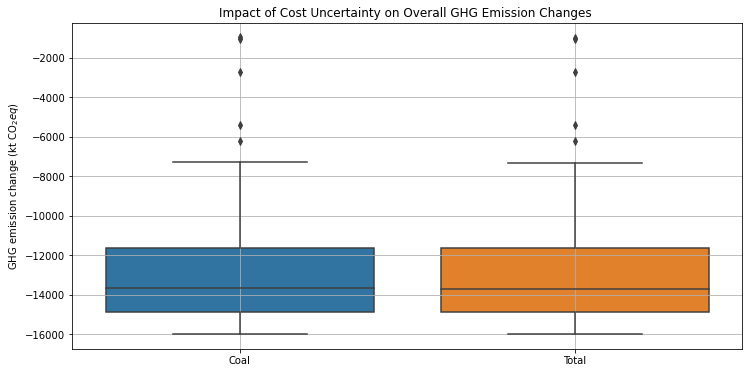

In [31]:
# Plot boxplots for mix_1 and mix_2 columns

# df_unit_obj_02 = pd.read_csv(os.path.join(folder_GHG,"result_02_100_300.csv"))
# df_unit_obj_02['obj_value'] = -df_unit_obj_02['obj_value']
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_unit_obj_02[['mix_1', 'obj_value']])
plt.title('Impact of Cost Uncertainty on Overall GHG Emission Changes ')
plt.ylabel('GHG emission change (kt CO$_2eq$)')
plt.xticks([0, 1], ['Coal',  'Total'])
plt.grid(True)

filepath = os.path.join(analysis_folder, f'Overall GHG Emission Changes_{num_samples}.png')
plt.savefig(filepath) 
plt.show()

## 8 结果处理

In [32]:
# 处理完文件导出位置
output_path = os.path.join(folder_GHG, "num_processed")
os.makedirs(output_path, exist_ok=True)

In [33]:
origin_cfpp = ['opt_weight_cfpp' 
               ,'Fuel combustion','Sludge treatment','Sludge dehydration','Sludge transport','Coal mining and processing'
               ,'Total_emission_change'
               ,'Transportation cost','Fuel cost change','Sludge treatment fee','Co-combustion cost'
               ,'Economic_total']

to_update_cfpp = ['opt_weight_cfpp'
                ,'GHGE_C1','GHGE_C2','GHGE_C3','GHGE_C4','GHGE_C5','GHGE_Ctotal'
                ,'E_C1','E_C2','E_C3','E_C4','E_Ctotal']

column_map_cfpp = dict(zip(to_update_cfpp, origin_cfpp))

In [34]:
origin_wipp = ['opt_weight_wipp' 
               ,'Fuel combustion','Sludge treatment','Sludge dehydration','Sludge transport'
               ,'Total_emission_change'
               ,'Transportation cost','Sludge treatment fee','Co-combustion cost'
               ,'Economic_total']

to_update_wipp = ['opt_weight_wipp'
               ,'GHGE_W1','GHGE_W2','GHGE_W3','GHGE_W4'
               ,'GHGE_Wtotal'
               ,'E_W1','E_W2','E_W3'
               ,'E_Wtotal']

column_map_wipp = dict(zip(to_update_wipp, origin_wipp))

In [35]:
# to get provincial list
df_tile = pd.read_excel(r"E:\Test\Outputs\FWC_03_S1\Tile_Grid_Map_Arrangement.xlsx")

# to_dict - map
df_plant_wwtp = pd.read_excel(r"E:\Test\Inputs\wastewater_treatment_plants_5218.xlsx")
i_province = df_plant_wwtp.set_index('FID')['Pro_en'].to_dict()

j_province = df_plant_coal.set_index('FID')['Province'].to_dict()
k_province = df_plant_waste.set_index('FID')['Pro_en'].to_dict()

j_cl = df_plant_coal.set_index('FID')['Capacity_MW'].to_dict()
k_cl = df_plant_waste.set_index('FID')['Capacity_elec_MW'].to_dict()

bins = [0, 50, 100, 500, 1000, 4000]
labels = ['0-50', '50-100', '100-500', '500-1000', '>1000']

In [36]:
I_total_by_num = []

for num in range(100):    

    file_cfpp = os.path.join(folder_GHG,fr"GHG_02_cfpp_{num}.csv")
    file_wipp = os.path.join(folder_GHG,fr"GHG_02_wipp_{num}.csv")
    df_cfpp = pd.read_csv(file_cfpp)
    df_wipp = pd.read_csv(file_wipp)
    
    sum_cfpp = df_cfpp.groupby('I')['opt_weight_cfpp'].sum().reset_index()
    sum_wipp = df_wipp.groupby('I')['opt_weight_wipp'].sum().reset_index()
    merged = pd.merge(sum_cfpp, sum_wipp, on='I', how='outer')
    merged['num'] = num
    merged = merged[['num', 'I', 'opt_weight_cfpp', 'opt_weight_wipp']]
    I_total_by_num.append(merged)
    


    # Convert to MultiIndex DataFrame for easy lookup
    df_cfpp.set_index(['I', 'J', 'M'], inplace=True)
    df_wipp.set_index(['I', 'K', 'M'], inplace=True)
    

    for col in origin_cfpp[1:]:  # 从第二个元素开始遍历
        df_cfpp[col] = 0
    df_cfpp['distance'] = 0
    
    df_cfpp['Fuel combustion'] = df_cfpp['opt_weight_cfpp'] * (GHG_SludgeBurn - 0.48 * GHG_CoalBurn) 
    df_cfpp['Coal mining and processing'] = -df_cfpp['opt_weight_cfpp']* 0.48 * GHG_CoalMini
    
    df_cfpp['Co-combustion cost'] = df_cfpp['opt_weight_cfpp']*TC_coal[num] 
    
    opt_weight_cfpp = df_cfpp['opt_weight_cfpp']
    for i, j, m in df_cfpp.index:
        opt_weight = opt_weight_cfpp.loc[(i, j, m)]
        df_cfpp.loc[(i, j, m), 'Sludge treatment'] = -opt_weight * SludgeTreatmentfactor[i, m]
        df_cfpp.loc[(i, j, m), 'Sludge dehydration'] = opt_weight * 28 * GHG_Elec_coal[j]
        df_cfpp.loc[(i, j, m), 'Sludge transport'] = opt_weight * GHG_SludgeTrans * Distance_CFPP[i, j]
        
        df_cfpp.loc[(i, j, m), 'Transportation cost'] = opt_weight * Distance_CFPP[i, j] * 0.65 
        df_cfpp.loc[(i, j, m), 'Fuel cost change'] = -opt_weight *0.48 * Coal_price[j] 
        df_cfpp.loc[(i, j, m), 'Sludge treatment fee'] = -opt_weight * NC_old[num,i,m]
        
        df_cfpp.loc[(i, j, m), 'distance'] = Distance_CFPP[i, j] 

    df_cfpp['Total_emission_change'] = df_cfpp[['Fuel combustion','Sludge treatment','Sludge dehydration','Sludge transport','Coal mining and processing']].sum(axis=1)
    df_cfpp['Economic_total'] = df_cfpp[['Transportation cost','Fuel cost change','Sludge treatment fee','Co-combustion cost']].sum(axis=1) 
    
        
    df_cfpp.reset_index(inplace=True)
    df_cfpp['i_pro'] = df_cfpp['I'].map(i_province)
    df_cfpp['j_pro'] = df_cfpp['J'].map(j_province)
    df_cfpp['cap_level'] = df_cfpp['J'].map(j_cl)
    df_cfpp['Cap_group'] = pd.cut(df_cfpp['cap_level'], bins=bins, labels=labels, include_lowest=True)
    
    cfpp_processed = os.path.join(output_path, fr"cfpp_{num}.csv")
    df_cfpp.to_csv(cfpp_processed, index=False)
    
      
            
    for col in origin_wipp[1:]:  
        df_wipp[col] = 0
    df_wipp['distance'] = 0   
    
    df_wipp['Fuel combustion'] = df_wipp['opt_weight_wipp'] * GHG_SludgeBurn 
   
    opt_weight_wipp = df_wipp['opt_weight_wipp']
    for i, k, m in df_wipp.index:
        opt_weight = opt_weight_wipp.loc[(i, k, m)]
        
        df_wipp.loc[(i, k, m), 'Sludge treatment'] = -opt_weight * SludgeTreatmentfactor[i, m]
        df_wipp.loc[(i, k, m), 'Sludge dehydration'] = opt_weight * 28 * GHG_Elec_waste[k] 
        df_wipp.loc[(i, k, m), 'Sludge transport'] = opt_weight * GHG_SludgeTrans * Distance_WIPP[i, k]
        
        df_wipp.loc[(i, k, m), 'Transportation cost'] = opt_weight * Distance_WIPP[i,k]*0.65 
        df_wipp.loc[(i, k, m), 'Sludge treatment fee'] = -opt_weight * NC_old[num,i,m] 
        df_wipp.loc[(i, k, m), 'Co-combustion cost'] = opt_weight * NC_cowaste[num] 
        
        df_wipp.loc[(i, k, m), 'distance'] = Distance_WIPP[i,k] 
    
    df_wipp['Total_emission_change'] = df_wipp[['Fuel combustion','Sludge treatment','Sludge dehydration','Sludge transport']].sum(axis=1) 
    df_wipp['Economic_total'] = df_wipp[['Transportation cost','Sludge treatment fee','Co-combustion cost']].sum(axis=1)

        
    df_wipp.reset_index(inplace=True)
    df_wipp['i_pro'] = df_wipp['I'].map(i_province)
    df_wipp['k_pro'] = df_wipp['K'].map(k_province)
    df_wipp['cap_level'] = df_wipp['K'].map(k_cl)
    df_wipp['Cap_group'] = pd.cut(df_wipp['cap_level'], bins=bins, labels=labels, include_lowest=True)
    
    wipp_processed = os.path.join(output_path, fr"wipp_{num}.csv")
    df_wipp.to_csv(wipp_processed, index=False)    
    
                        
I_total = pd.concat(I_total_by_num, ignore_index=True)
I_total.to_csv(os.path.join(analysis_folder, fr"I_total_by_num.csv"),index=False)